# Car Price Prediction Project (Part II - Handling Missing Values & Feature Refinement)

**Building on Part I:**

In the initial phase of this project, "Cleaning Data," we tackled the foundational task of transforming a raw dataset of car listings into a more structured format. We addressed issues such as incorrect data types, inconsistent formatting, and initial feature parsing, reducing the dataset from 58 to a more manageable number of columns while striving to preserve valuable information.

**Notebook Objective (Part II):**

This notebook focuses on the critical next step: **handling missing values** and further **refining features** based on deeper insights. While Part I cleaned up the existing data, significant gaps remained. Here, our primary goal is to intelligently impute missing information and transform complex or raw features into more analytically useful representations, thereby enhancing the dataset's quality for subsequent modeling. This involved a meticulous process of cross-referencing columns, leveraging domain knowledge (e.g., understanding car specifications, emission standards, equipment packages), and employing targeted data extraction techniques.

**Key Activities & Insights Gained in this Phase:**

-   **Targeted NaN Imputation:** Instead of generic imputation, missing values in crucial columns like `paint`, `seats`, `gearbox`, `drivetrain`, `cylinders`, `fuel_consumption`, `empty_weight`, and `previous_owner` were addressed by:
    -   Extracting information from textual columns like `short_description`, `description`, and `manufacturer_color` using string methods and regular expressions (e.g., identifying "metallic" paint, "manual" gearboxes, or "5 seats").
    -   Leveraging domain knowledge, such as understanding that electric cars have zero CO₂ tailpipe emissions and typically zero cylinders, or that Euro emission standards began at a specific year.
    -   Using `groupby` operations with appropriate aggregate functions (mode or median) based on related features (e.g., filling `empty_weight` based on `make`, `model`, and `engine_size`).
-   **Feature Transformation & Creation:**
    -   The `power` column was processed to extract numerical horsepower values.
    -   `engine_size` was standardized to Liters.
    -   Complex list-like columns (`comfort_convenience`, `entertainment_media`, `safety_security`, `extras`) were converted into numerical "package count" features, which were then binned into meaningful tiers (e.g., "Standard," "Premium," "Deluxe") based on their distributions.
    -   Understanding the nuances between emission standards like "Euro 6," "Euro 6d," and "Euro 6d-TEMP" informed their handling.
-   **Data Reduction through Informed Decisions:** The dataset was further refined from approximately 29,480 observations with numerous columns (post-initial cleaning) to 28,630 observations and 30 well-defined columns, demonstrating a commitment to preserving data integrity while enhancing feature quality.

By the end of this notebook, we have a dataset with significantly fewer missing values and features that are more directly interpretable and ready for advanced exploratory data analysis, outlier treatment, and ultimately, model training. The insights gained into inter-column relationships and the impact of specific features (like the number of comfort or safety options) will be invaluable in the subsequent stages.

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [3]:
df0 = pd.read_csv("car_project_clean.csv")
df = df0.copy()

In [5]:
df.head(3)

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner
0,Mercedes-Benz A 160,CDi,Mercedes-Benz,A 160,"P.I. EL PALMAR C/FORJA 6, 11500 PUERTO DE SAN...",16950.0,Compact,Used,5.0,Spain,7468157,24 months,120200.0,2016-06,Manual,Diesel,Black,Metallic,",Precio al contado: 16950 euros, , ,Vehículo ...",Dealer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mercedes-Benz EQE 350,350+,Mercedes-Benz,EQE 350,"APARTADO DE CORREOS 1032, 26140 LOGROÑO, ES",80900.0,Compact,Pre-registered,4.0,Spain,7054863,24 months,5000.0,2022-06,Automatic,Electric,NaN,NaN,",Precio al contado: 88900 euros, ,AUTO OJA S....",Dealer,5.0,215 kW (292 hp),1.0,9.0,0 g/km (comb.),Negro Obsidiana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mercedes-Benz A 45 AMG,S 4Matic+ 8G-DCT,Mercedes-Benz,A 45 AMG,"PORT. TARRACO, MOLL DE LLEVANT, Nº 5, LOC. 6-8...",69900.0,Compact,Used,5.0,Spain,7410454,12 months,18900.0,2020-07,Automatic,Gasoline,Grey,NaN,"Gris MANUFAKTUR mountaingrau magno, ,Linea/Est...",Dealer,5.0,310 kW (421 hp),1991.0,8.0,NaN,Mountaingrau magno,4WD,4.0,"8.4 l/100 km (comb.),10.9 l/100 km (city),5.8 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29480 entries, 0 to 29479
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   make_model            28630 non-null  object 
 1   short_description     28417 non-null  object 
 2   make                  28630 non-null  object 
 3   model                 28354 non-null  object 
 4   location              28630 non-null  object 
 5   price                 28630 non-null  float64
 6   body_type             28630 non-null  object 
 7   type                  28630 non-null  object 
 8   doors                 28271 non-null  float64
 9   country_version       16889 non-null  object 
 10  offer_number          23100 non-null  object 
 11  warranty              15784 non-null  object 
 12  mileage               28629 non-null  float64
 13  first_registration    28628 non-null  object 
 14  gearbox               28382 non-null  object 
 15  fuel_type          

In [9]:
df.shape

(29480, 42)

In [11]:
# Dropping rows full of null values

df.dropna(how='all', inplace=True)

In [13]:
df.shape

(28630, 42)

In [15]:
df.isnull().sum() / len(df) * 100

make_model               0.000000
short_description        0.743975
make                     0.000000
model                    0.964024
location                 0.000000
price                    0.000000
body_type                0.000000
type                     0.000000
doors                    1.253929
country_version         41.009431
offer_number            19.315403
warranty                44.869019
mileage                  0.003493
first_registration       0.006986
gearbox                  0.866224
fuel_type                6.241705
color                    6.021656
paint                   49.371289
description              2.343695
seller                   0.000000
seats                   10.915124
power                    1.997904
engine_size              4.900454
gears                   33.796717
co2_emissions           35.054139
manufacturer_color      23.901502
drivetrain              40.995459
cylinders               34.152986
fuel_consumption        18.319944
comfort_conven

## Handling Missing Values

In [17]:
df['registration_year'] = df.first_registration.str.split('-', expand=True).iloc[:, 0].astype('float')

### make_model

In [19]:
df.make_model.isnull().sum()

0

In [21]:
df.make_model.value_counts()[:20]

make_model
Renault Megane    863
SEAT Leon         787
Volvo V40         740
Dacia Sandero     730
Hyundai i30       706
Volvo C70         692
Opel Astra        675
Ford Mustang      663
Peugeot 308       537
Ford Focus        495
Nissan Qashqai    490
SEAT Ibiza        442
Fiat 500          440
Fiat Tipo         430
Renault Clio      417
Ford Fiesta       400
Nissan Micra      390
Fiat 500X         376
Skoda Octavia     371
Opel Corsa        366
Name: count, dtype: int64

### make

In [23]:
df.make.isnull().sum()

0

In [25]:
df.make.value_counts()

make
Volvo            3659
Mercedes-Benz    2398
Opel             2385
Peugeot          2360
Renault          2351
Fiat             2338
Ford             2324
Nissan           2064
Toyota           2038
Hyundai          1867
SEAT             1743
Skoda            1566
Dacia            1537
Name: count, dtype: int64

### model

In [27]:
df.model.isnull().sum()

276

**Mercedes-Benz**

In [29]:
null_models = df[df.model.isnull()]

In [31]:
model_list = df[df.make == 'Mercedes-Benz'].model.unique()

model_list_cleaned = sorted(set(m.strip() for m in model_list if isinstance(m, str)), key=len, reverse=True)

pattern = r'\b(' + '|'.join(re.escape(model) for model in model_list_cleaned) + r')\b'

def extract_model(description):
    match = re.search(pattern, description)
    return match.group(0) if match else np.nan

sd_mercedes = null_models[null_models.make == 'Mercedes-Benz'].short_description.apply(extract_model).dropna()
d_mercedes = null_models[null_models.make == 'Mercedes-Benz'].description.apply(extract_model).dropna()

df.loc[sd_mercedes.index, 'model'] = sd_mercedes.values
df.loc[d_mercedes.index, 'model'] = d_mercedes.values

In [33]:
df[(df.make == 'Mercedes-Benz') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
427,Mercedes-Benz,SL 43 DIGITAL LIGHT+BURMESTER+DISTRO+HUD+MEMORY,Mercedes-Benz,NaN,"St.-Georgener-Straße 1, 79111 Freiburg, DE",159850.0,Convertible,Demonstration,2.0,NaN,FR-KE535,Yes,2001.0,2022-09,Automatic,Super E10 95 (Particle filter),White,NaN,"Verbrauch und Emission (WLTP),Primärer Antrieb...",Dealer,4.0,280 kW (381 hp),1991.0,NaN,212 g/km (comb.),Manufaktur opalithweiß bright,NaN,4.0,"9.4 l/100 km (comb.),13.9 l/100 km (city),8.9 ...","360° camera, Air conditioning, Armrest, Automa...","Android Auto, Apple CarPlay, Bluetooth, Digita...","ABS, Adaptive Cruise Control, Alarm system, Bl...","Alloy wheels (21""), Ambient lighting, Automati...",1810.0,New,Yes,Yes,Euro 6,NaN,Black,Full Leather,1.0,2022.0
766,Mercedes-Benz,C 63 S AMG Cabrio *AMG-DRIVERS*PERF-ABGAS*VOLL*,Mercedes-Benz,NaN,"Robert-Bosch-Str. 32, 72348 Rosenfeld, DE",76890.0,Convertible,Used,2.0,Germany,866-047,NaN,45630.0,2018-02,Automatic,Super 95,Grey,Metallic,"WWW.BOVENTA.DE,BESCHREIBUNG,unfallfrei,kein Re...",Dealer,4.0,375 kW (510 hp),3982.0,7.0,208 g/km (comb.),Selenitgrau Metallic,NaN,NaN,"8.9 l/100 km (comb.),12 l/100 km (city),7.2 l/...","Air conditioning, Armrest, Cruise control, Ele...","Bluetooth, CD player, Hands-free equipment, In...","ABS, Adaptive Cruise Control, Adaptive headlig...","Alloy wheels, Ambient lighting, Automatically ...",1925.0,New,Yes,NaN,Euro 6,4 (Green),Black,Full Leather,NaN,2018.0
922,Mercedes-Benz,GLE 63 4MATIC Coupé LED*Abst-Tempo*360 Grad*No...,Mercedes-Benz,NaN,"Hauptstraße 24-25, 13127 Berlin Französisch-B...",60999.0,Coupe,Used,5.0,NaN,A052942,NaN,75400.0,2016-10,Automatic,Super 95,White,NaN,"Sonderausstattung,Abstandsregeltempomat Distro...",Dealer,5.0,410 kW (557 hp),5461.0,NaN,278 g/km (comb.),Weiß,4WD,NaN,"11.9 l/100 km (comb.),15.8 l/100 km (city),9.7...","Air suspension, Armrest, Automatic climate con...","Bluetooth, Hands-free equipment, MP3, On-board...","ABS, Adaptive Cruise Control, Blind spot monit...","Alloy wheels, Ambient lighting, Automatically ...",2350.0,New,Yes,Yes,Euro 6,4 (Green),Black,Full Leather,4.0,2016.0
1229,Mercedes-Benz,ANDERE AMG UNTERBODEN GESTRAHLT KONSERVIERT/SHZ,Mercedes-Benz,NaN,"Alte Bundesstr. 45, 71332 Waiblingen, DE",69500.0,Off-Road/Pick-up,Used,5.0,NaN,31013,NaN,146000.0,1997-10,Automatic,Regular/Benzine 91,Silver,Metallic,"unfallfrei, scheckheftgepflegt, Nichtraucher, ...",Dealer,4.0,200 kW (272 hp),3606.0,NaN,0 g/km (comb.),Silber brillantsilber metallic,4WD,NaN,0 l/100 km (comb.),"Air conditioning, Cruise control, Electrically...",On-board computer,"Central door lock, Power steering",Steel wheels,NaN,New,Yes,Yes,NaN,4 (Green),Black,Full Leather,3.0,1997.0
1294,Mercedes-Benz,GLE 63 4MATIC Coupé LED*Abst-Tempo*360 Grad*No...,Mercedes-Benz,NaN,"Hauptstraße 24-25, 13127 Berlin Französisch-B...",60999.0,Off-Road/Pick-up,Used,5.0,NaN,A052942P,NaN,75400.0,2016-10,Automatic,Super 95,White,NaN,"Sonderausstattung,Abstandsregeltempomat Distro...",Dealer,5.0,410 kW (557 hp),5461.0,NaN,278 g/km (comb.),Weiß,4WD,NaN,"11.9 l/100 km (comb.),15.8 l/100 km (city),9.7...","Air suspension, Armrest, Automatic climate con...","Bluetooth, Hands-free equipment, MP3, On-board...","ABS, Adaptive Cruise Control, Blind spot monit...","Alloy wheels, Ambient lighting, Automatically ...",2350.0,New,Yes,Yes,Euro 6,4 (Green),Black,Full Leather,4.0,2016.0
2116,Mercedes-Benz,e 4M L AMG-CHAUFFEUR-PANO-EXKLUSIV PAKET,Mercedes-Benz,NaN,"Gewerbestraße 19, 86707 Westendorf, DE",179995.0,Sedan,Demonstration

In [35]:
missing_mercedes = ['SL 43 AMG', 'C 63 AMG', 'GLE 63', 'G', 'GLE 63', np.nan, 'ML 63 AMG', 'S 580', np.nan]
missing_index = df[(df.make == 'Mercedes-Benz') & (df.model.isnull())].index

df.loc[missing_index, 'model'] = missing_mercedes

In [37]:
df.loc[[2116, 2234], 'model'] = 'EQS'

**Opel**

In [40]:
df[(df.make == 'Opel') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
2917,Opel,2.0 CDTi S/S 165 CV Excellence,Opel,NaN,"Ctra. del Mig, 96,, 08097 L'Hospitalet de Llo...",9990.0,Convertible,Used,2.0,Spain,7367286,12 months,166345.0,2014-04,Manual,Diesel,Black,NaN,",Precio al contado: 11990 euros, ,Para compra...",Dealer,NaN,121 kW (165 hp),2000.0,NaN,NaN,Negro,NaN,NaN,"5.2 l/100 km (comb.),6.3 l/100 km (city),4.6 l...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.0
2921,Opel,2.0 CDTi S/S 165 CV Excellence,Opel,NaN,"Calle Comercio s/n del polígono El Florío, 18...",9990.0,Convertible,Used,2.0,Spain,7366227,12 months,166345.0,2014-04,Manual,Diesel,Black,NaN,",Precio al contado: 11990 euros, ,Para compra...",Dealer,NaN,121 kW (165 hp),2000.0,NaN,NaN,Negro,NaN,NaN,"5.2 l/100 km (comb.),6.3 l/100 km (city),4.6 l...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.0
2923,Opel,Cabrio 1.6T S&S Excellence Aut.,Opel,NaN,"AVD. ARIAS DE VELASCO Nº 35, 29601 MARBELLA, ES",19900.0,Convertible,Used,2.0,Spain,7394441,12 months,24945.0,2017-05,Automatic,Gasoline,Blue,NaN,OPEL CASCADA 1.6T EXCELLENCE 170CV AUTOMÁTICO....,Dealer,4.0,125 kW (170 hp),1598.0,6.0,NaN,NaN,Front,4.0,"7.2 l/100 km (comb.),9.3 l/100 km (city),5.9 l...","Air conditioning, Automatic climate control, C...","Bluetooth, CD player, MP3, On-board computer","ABS, Central door lock, Driver-side airbag, El...",NaN,1733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.0
2924,Opel,1.4 Turbo Excellence,Opel,NaN,"CARRETERA FUENCARRAL A HORTALEZA 89 D, 28050 ...",15754.0,Convertible,Used,2.0,Spain,7305501,12 months,44944.0,2018-01,Manual,Gasoline,NaN,NaN,",Precio al contado: 17299 euros, ,AUTOHERO | ...",Dealer,NaN,103 kW (140 hp),1400.0,NaN,NaN,Marrón,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0
2926,Opel,1.4 T S/S Excellence,Opel,NaN,"Ctra. del Mig, 96,, 08097 L'Hospitalet de Llo...",14990.0,Convertible,Used,2.0,Spain,7202029,12 months,66700.0,2016-04,Manual,Gasoline,Grey,NaN,",Precio al contado: 16990 euros, ,Para compra...",Dealer,NaN,103 kW (140 hp),1400.0,NaN,NaN,Gris,NaN,NaN,"6.4 l/100 km (comb.),7.9 l/100 km (city),5.5 l...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.0
2927,Opel,1.4 Turbo Excellence,Opel,NaN,"Plaza de Europa, S/N Centro Comercial Gran Tur...",15754.0,Convertible,Used,2.0,Spain,7305311,12 months,44944.0,2018-01,Manual,Gasoline,NaN,NaN,",Precio al contado: 17299 euros, ,AUTOHERO | ...",Dealer,NaN,103 kW (140 hp),1400.0,NaN,NaN,Marrón,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0
2928,Opel,Cabrio 1.4T S&S Excellence,Opel,NaN,"Rúa do Gandarón, 48, 36214 Vigo, ES",15421.0,Convertible,Used,2.0,Spain,7409781,12 months,62703.0,2015-03,Manual,Gasoline,Red,NaN,",Precio al contado: 16500 euros, ,Ref. 9231J...",Dealer,4.0,103 kW (140 hp),1362.0,6.0,NaN,Rojo,Front,4.0,"6.3 l/100 km (comb.),7.8 l/100 km (city),5.4 l...","Air conditioning, Automatic climate control, C...","Bluetooth, CD player, MP3, On-board computer","ABS, Central door lock, Driver-side airbag, El...",Alloy wheels,1701.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015.0
2931,Opel,Cabrio 1.6T S&S Excellence Aut.,Opel,NaN,"CALLE ALGUER Nº2, 08830 SANT BOI DE LLOBREGAT...",18550.0,Convertible,Used,2.0,Spain,7316510,12 months,52345.0,2014-11,Automatic,Gasoline,White,NaN,",Precio al contado: 20400 euros, ,Crestanevad...",Dealer,4.0,125 kW (170 hp),1598.0,6.0,NaN,NaN,Front,4.0,"7.2 l/100 km (comb.),9.3 l/100 km (city),5.9 l...","Air conditioning, Automatic climate control, C...","Bluetooth, CD player, MP3, 

In [42]:
df.loc[3367, 'model'] = 'Olympia'
df.loc[3387, 'model'] = 'Astra'

In [44]:
df[df.make == 'Opel'].short_description.value_counts()

short_description
Cabrio 1.4T S&S Excellence                            85
Coupé 2.2 16v Bertone Edition                          8
Innovation ecoFlex                                     6
ST 1.6CDTi Dynamic 110                                 6
H GTC Edition                                          5
                                                      ..
1.4 * Teilleder * Sitzhzg. * Klimaauto. *              1
H 1,8 GTC Sport                                        1
1.2T S/S Design & Tech 130                             1
J GTC 2.0 CDTI Active/NAVI/SHZ/USB/EU5                 1
2.0 CDTi TOIT OUVRANT XENON CAPTEURS GPS ** FULL**     1
Name: count, Length: 2066, dtype: int64

In [46]:
opel_index = df[df.short_description == 'Cabrio 1.4T S&S Excellence'].model.index

df.loc[opel_index, 'model'] = 'Cascada'

In [48]:
opel_nulls = df[df.make == 'Opel'][df[df.make == 'Opel'].model.isnull()]
astra_index = opel_nulls[opel_nulls.short_description.str.contains('1.4')].index
df.loc[astra_index, 'model'] = 'Astra'

In [50]:
cascada_index = opel_nulls[opel_nulls.short_description.str.contains('1.6')].index
df.loc[cascada_index, 'model'] = 'Cascada'

In [52]:
astra_2_index = opel_nulls[opel_nulls.short_description.str.contains('2.0')].index
df.loc[astra_2_index, 'model'] = 'Astra'

**Fiat**

In [55]:
df[(df.make == 'Fiat') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
9762,Fiat,Neuer 500 ICON 42kWh MJ22 ICON NAVI SITZHZG. M...,Fiat,NaN,"Gießener Straße 122-124, 35415 Pohlheim, DE",27975.0,Compact,Demonstration,3.0,Germany,407EH,Yes,6000.0,2022-04,Automatic,NaN,Grey,Metallic,"Getriebe,Automatikgetriebe, 1 Gang,Ausstattung...",Dealer,4.0,87 kW (118 hp),NaN,1.0,NaN,Mineral grau,Front,NaN,NaN,"Air conditioning, Armrest, Automatic climate c...","Bluetooth, Digital cockpit, Digital radio, Han...","ABS, Blind spot monitor, Central door lock, Da...","Alloy wheels (16""), Winter package",1365.0,04/2025,Yes,Yes,Euro 6d,NaN,Black,Cloth,1.0,2022.0
9995,Fiat,124 Spyder Lusso+LED+Navi+BOSE+Vollleder+Kamera,Fiat,NaN,"Nedderfeld 29, 22529 Hamburg, DE",22999.0,Convertible,Used,2.0,Germany,HHN-133373,Yes,5150.0,2018-10,Manual,Gasoline,Blue,Metallic,"Highlights:,Getriebe 6-Gang,Sicht-Paket, (Leuc...",Dealer,2.0,103 kW (140 hp),1368.0,NaN,NaN,COLORE ESTERNO (DEEP CRYSTAL B,NaN,NaN,NaN,"Air conditioning, Armrest, Automatic climate c...","Bluetooth, CD player, Digital radio, Hands-fre...","ABS, Adaptive headlights, Central door lock, D...","Alloy wheels, Automatically dimming interior m...",NaN,10/2023,Yes,Yes,Euro 6,4 (Green),Beige,Full Leather,1.0,2018.0
10095,Fiat,PININFARINA Spider 2000,Fiat,NaN,"Bornsestraat 51a, 7597 NH SAASVELD, NL",15000.0,Convertible,Used,2.0,Netherlands,2546579,NaN,1.0,1981-01,Manual,Gasoline,White,NaN,"Welkom bij Maxima Classic Cars te Saasveld, wi...",Dealer,2.0,NaN,0.0,NaN,NaN,-,NaN,NaN,"0 l/100 km (comb.),0 l/100 km (city),0 l/100 k...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1981.0
10104,Fiat,522L Cabriolet,Fiat,NaN,"Werner-von-Siemens-Str. 2, 86551 Aichach, DE",159000.0,Convertible,Used,4.0,NaN,L001564,NaN,999999.0,1933-07,Manual,Gasoline,Brown,NaN,Vollrestauration eines äußerst seltenen FIAT 5...,Dealer,NaN,38 kW (52 hp),2518.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,Full Leather,NaN,1933.0
10145,Fiat,124 Spider 1.4 MultiAir Turbo Lusso Automatik,Fiat,NaN,"Gutenbergstr. 10, 89518 Heidenheim, DE",19989.0,Convertible,Used,2.0,Germany,175,NaN,50281.0,2018-04,Automatic,Regular/Benzine 91,Black,Metallic,"Nummer für Anfragen: 175,FIN: ZFANF6E4A0011836...",Dealer,2.0,103 kW (140 hp),1368.0,NaN,153 g/km (comb.),JET BLACK (METALLIC),NaN,NaN,"6.6 l/100 km (comb.),9.1 l/100 km (city),5.2 l...","Air conditioning, Armrest, Automatic climate c...","Bluetooth, Hands-free equipment, On-board comp...","ABS, Central door lock, Driver-side airbag, El...","Alloy wheels, Headlight washer system, Sport s...",NaN,New,NaN,NaN,Euro 6,4 (Green),Black,Full Leather,1.0,2018.0
10319,Fiat,124 Spider Lusso Leder Klima Rückfahrkamera 1 HA,Fiat,NaN,"Hattersheimer Str. 6a, 65719 Hofheim, DE",21890.0,Convertible,Used,2.0,Germany,NaN,Yes,28000.0,2018-09,Manual,Regular/Benzine 91,Grey,Metallic,"Fiat 124 Spider,Sonderedition ""Lusso"",1. Hand,...",Dealer,2.0,103 kW (140 hp),1368.0,NaN,148 g/km (comb.),COLORE ESTERNO (METEOR GREY),NaN,NaN,"6.4 l/100 km (comb.),8.5 l/100 km (city),5.1 l...","Air conditioning, Armrest, Automatic climate c...","Android Auto, Apple CarPlay, Bluetooth, CD pla...","ABS, Adaptive headlights, Central door lock, D...","Alloy wheels, Automatically dimming interior m...",NaN,New,Yes,Yes,Euro 6c,NaN,Black,Full Leather,1.0,2018.0
10430,Fiat,850c coupe,Fiat,NaN,"Fichtenstraße 40, 78087 Mönchweiler, DE",11000.0,Coupe,Used,2.0,NaN,50,NaN,90000.0,1967-03,Manual,Gasoline,Blue,NaN,ANGEBOTEN EIN FIAT 850SPORTCOUPE IN EINEM RICH...,Dealer,4.0,35 kW (48

In [57]:
fiat_spider = null_models[null_models.make == 'Fiat'][null_models[null_models.make == 'Fiat'].short_description.str.contains('Spider|Spyder')]

df.loc[fiat_spider.index, 'model'] = '124 Spider'

In [59]:
model_list = df[df.make == 'Fiat'].model.unique()

model_list_cleaned = sorted(set(m.strip() for m in model_list if isinstance(m, str)), key=len, reverse=True)

pattern = r'\b(' + '|'.join(re.escape(model) for model in model_list_cleaned) + r')\b'

fiat_nulls = null_models[null_models.make == 'Fiat'].short_description.apply(extract_model).dropna()

df.loc[fiat_nulls.index, 'model'] = fiat_nulls.values

In [61]:
model_list = df[df.make == 'Fiat'].model.unique()

model_list_cleaned = sorted(set(m.strip() for m in model_list if isinstance(m, str)), key=len, reverse=True)

pattern = r'\b(' + '|'.join(re.escape(model) for model in model_list_cleaned) + r')\b'

fiat_d_nulls = null_models[null_models.make == 'Fiat'].description.apply(extract_model).dropna()
df.loc[fiat_d_nulls.index, 'model'] = fiat_d_nulls.values

In [63]:
df.loc[10660, 'model'] = '595 Abarth'

In [65]:
coupes = df[(df.make == 'Fiat') & (df.model.isnull())].short_description.str.lower().str.contains('coupe|coupè|coupé')
coupes_index = coupes[coupes == True].index
df.loc[coupes_index, 'model'] = 'Coupe'

In [67]:
df[(df.make == 'Fiat') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
10104,Fiat,522L Cabriolet,Fiat,NaN,"Werner-von-Siemens-Str. 2, 86551 Aichach, DE",159000.0,Convertible,Used,4.0,NaN,L001564,NaN,999999.0,1933-07,Manual,Gasoline,Brown,NaN,Vollrestauration eines äußerst seltenen FIAT 5...,Dealer,NaN,38 kW (52 hp),2518.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,Full Leather,NaN,1933.0
10474,Fiat,"Fiat 124 BC1 , BJ. 1971",Fiat,NaN,"2540 Bad Vöslau, AT",15000.0,Coupe,Used,2.0,NaN,NaN,NaN,41263.0,1971-06,Manual,Gasoline,Yellow,NaN,"Verkaufe FIAT BC1 , für Oldtimerrallyes umfass...",Private Seller,2.0,81 kW (110 hp),1600.0,5.0,200 g/km (comb.),NaN,NaN,4.0,"10 l/100 km (comb.),11 l/100 km (city),9 l/100...",NaN,NaN,NaN,Sport package,950.0,08/2023,NaN,NaN,Euro 1,NaN,Black,Alcantara,3.0,1971.0
10631,Fiat,1500 VIGNALE 1Â° SERIE,Fiat,NaN,"Via Beretta, 8, 40016 San Giorgio di Piano - ...",29500.0,Coupe,Used,2.0,NaN,1228517,NaN,26000.0,1966-04,Manual,Regular/Benzine E10 91,NaN,Metallic,"VETTURA OMOLOGATA ASI,COMPLETAMENTE RESTAURATA...",Dealer,2.0,56 kW (76 hp),1500.0,4.0,NaN,NaN,Front,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Euro 1,NaN,NaN,Other,NaN,1966.0
11346,Fiat,Fiat 1500 Familiare OSI,Fiat,NaN,"Ellwanger Strasse 100, 73441 Bopfingen, DE",16900.0,Station wagon,Used,4.0,NaN,NaN,NaN,68000.0,1966-02,Manual,Gasoline,White,NaN,So ein zweites Mal sicherlich nicht zu finden....,Dealer,NaN,57 kW (77 hp),1481.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NaN,NaN,NaN,NaN,Other,Full Leather,NaN,1966.0
11707,Fiat,1100D,Fiat,NaN,"16157 Genova, IT",7000.0,Sedan,Used,4.0,NaN,NaN,NaN,46000.0,1963-09,Manual,Gasoline,Grey,NaN,"Gloriosa fiat 1100D del 1963 iscritta all'ASI,...",Private Seller,5.0,35 kW (48 hp),1221.0,4.0,NaN,NaN,Rear,4.0,"8 l/100 km (comb.),10 l/100 km (city),7 l/100 ...","Fold flat passenger seat, Wind deflector",NaN,NaN,"Automatically dimming interior mirror, Spare t...",1225.0,05/2023,NaN,Yes,Euro 1,NaN,Red,Other,1.0,1963.0


In [69]:
df.loc[10104, 'model'] = '522'
df.loc[10474, 'model'] = '124'
df.loc[[10631, 11346], 'model'] = '1500'
df.loc[11707, 'model'] = '1100'

In [71]:
df[(df.make == 'Fiat')].model.value_counts().index

Index(['500', 'Tipo', '500X', '500C', 'Coupe', 'Panda', '124 Spider', '500L',
       '500e', 'Punto', 'Barchetta', '500 Abarth', 'Punto Evo', 'Grande Punto',
       '850', 'Dino', 'New Panda', 'Fullback', '124 Coupè', 'Freemont', 'Qubo',
       '130', '595 Abarth', 'Bravo', 'Sedici', 'Spider Europa', 'Uno', '128',
       '600', '131', '126', 'Croma', 'Seicento', 'Stilo', 'Ritmo', 'Strada',
       'Talento', '1500', '127', 'X 1/9', 'Fiorino', 'Doblo', 'Multipla',
       '522', 'Cinquecento', '124', 'Brava', '1100'],
      dtype='object', name='model')

**Volvo**

In [74]:
df[(df.make == 'Volvo') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
26739,Volvo,2.4 Momentum *Youngtimer*,Volvo,NaN,"Galileistraat 2, 1704 SE HEERHUGOWAARD, NL",9900.0,Convertible,Used,2.0,Netherlands,2726634,3 months,203190.0,2007-06,Manual,Gasoline,Grey,Metallic,Zeer nette en goed onderhouden C70 cabriolet m...,Dealer,4.0,103 kW (140 hp),2435.0,NaN,212 g/km (comb.),-,NaN,5.0,"8.9 l/100 km (comb.),12.8 l/100 km (city),6.7 ...","Air conditioning, Automatic climate control, C...",On-board computer,"ABS, Central door lock with remote control, Dr...","Automatically dimming interior mirror, Sport s...",1598.0,New,Yes,Yes,Euro 4,NaN,NaN,Part Leather,NaN,2007.0
27062,Volvo,2.4 Momentum *Youngtimer*,Volvo,NaN,"Galileistraat 2, 1704 SE HEERHUGOWAARD, NL",9900.0,Convertible,Used,2.0,Netherlands,2726634,3 months,203190.0,2007-06,Manual,Gasoline,Grey,Metallic,Zeer nette en goed onderhouden C70 cabriolet m...,Dealer,4.0,103 kW (140 hp),2435.0,NaN,212 g/km (comb.),-,NaN,5.0,"8.9 l/100 km (comb.),12.8 l/100 km (city),6.7 ...","Air conditioning, Automatic climate control, C...",On-board computer,"ABS, Central door lock with remote control, Dr...","Automatically dimming interior mirror, Sport s...",1598.0,New,Yes,Yes,Euro 4,NaN,NaN,Part Leather,NaN,2007.0
27124,Volvo,Amazon coupe,Volvo,NaN,"3771LE Barneveld, NL",8750.0,Coupe,Used,2.0,NaN,NaN,NaN,60000.0,1968-08,Manual,Gasoline,White,NaN,Mooie volvo Amazon. Volvo verkeert in een keur...,Private Seller,5.0,84 kW (114 hp),NaN,4.0,NaN,NaN,Rear,4.0,NaN,NaN,NaN,NaN,NaN,1038.0,01/2023,NaN,Yes,NaN,NaN,Red,Cloth,5.0,1968.0
27130,Volvo,P 1800 E Automatik Restauriert,Volvo,NaN,"Koblenzer Str. 77, 53498 Bad Breisig, DE",29900.0,Coupe,Used,NaN,NaN,NaN,NaN,107933.0,1972-12,Automatic,Gasoline,NaN,NaN,Zum Verkauf steht ein wunderschöner P 1800 E A...,Dealer,NaN,91 kW (124 hp),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,Full Leather,NaN,1972.0
27185,Volvo,PV544 Sport B18 B20 Buckelvolvo,Volvo,NaN,"An Schormanns Busch 5, 32107 Bad Salzuflen, DE",17450.0,Coupe,Used,2.0,NaN,NaN,NaN,50000.0,1961-07,Manual,Gasoline,Red,NaN,∗∗∗∗ Ein Video zu diesem Fahrzeug sehen Sie au...,Dealer,5.0,90 kW (122 hp),2199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Sport package, Sport seats, Sport suspension",NaN,04/2023,NaN,NaN,NaN,NaN,Black,NaN,NaN,1961.0
27191,Volvo,444 kattenrug,Volvo,NaN,"Schoenmakerij 15, 4762 AS ZEVENBERGEN, NL",13950.0,Coupe,Used,2.0,NaN,1449606,NaN,12100.0,1955-02,Manual,Gasoline,Red,NaN,"Volvo 444 kattenrug,Hoewel alle gegevens met d...",Dealer,5.0,NaN,1600.0,NaN,NaN,Czerwony,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1955.0
27235,Volvo,VOLVO P1800 S,Volvo,NaN,"646 AVENUE DES PRES SEIGNEURS, 01120 LA BOISS...",39900.0,Coupe,Used,2.0,France,102505,1 months,54072.0,1967-01,Manual,Gasoline,Beige,NaN,"Ref : 102505Année : 1967 ,Km au compteur : 540...",Dealer,4.0,81 kW (110 hp),1990.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1967.0
27283,Volvo,Buckel Volvo,Volvo,NaN,"Hansestraße 5, 48165 Münster, DE",11900.0,Coupe,Used,2.0,NaN,NaN,NaN,46000.0,1953-07,Manual,Gasoline,Black,NaN,Sehr schönes originales Fahrzeug. Teilrestauri...,Dealer,5.0,32 kW (44 hp),1414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radio,NaN,NaN,NaN,New,NaN,NaN,NaN,NaN,Grey,Cloth,3.0,1953.0
27301,Volvo,P1800E,Volvo,NaN,"71036 Lucera (FG), IT",40000.0,Coupe,Used,2.0,NaN,NaN,NaN,174000.0,1970-06,Semi-automatic,Gasoline,Blue,NaN,Volvo P1800E si tratta dell'ultima serie con m...,Private Seller,4.0,80 kW (109 hp),1995.0,5.0,NaN,NaN,Rear,4.0,N

In [76]:
model_list = df[df.make == 'Volvo'].model.unique()

model_list_cleaned = sorted(set(m.strip() for m in model_list if isinstance(m, str)), key=len, reverse=True)

pattern = r'\b(' + '|'.join(re.escape(model) for model in model_list_cleaned) + r')\b'

sd_volvo = null_models[null_models.make == 'Volvo'].short_description.apply(extract_model).dropna()
d_volvo = null_models[null_models.make == 'Volvo'].description.apply(extract_model).dropna()

df.loc[sd_volvo.index, 'model'] = sd_volvo.values
df.loc[d_volvo.index, 'model'] = d_volvo.values

In [78]:
volvo_nulls = df[df.make == 'Volvo'][df[df.make == 'Volvo'].model.isnull()]
p_index = volvo_nulls[volvo_nulls.short_description.str.contains('P 1800|P1800')].index
df.loc[p_index, 'model'] = 'P1800'

In [80]:
df.loc[[27191, 27385], 'model'] = 'PV444'

In [82]:
df.loc[[27283, 27477], 'model'] = 'Buckel'

In [84]:
df.loc[[27638, 27681, 28036, 28079], 'model'] = 'XC40'

In [86]:
df[(df.make == 'Volvo')].model.value_counts().index

Index(['V40', 'C70', 'XC60', 'V60', 'C30', 'XC90', 'V90', 'XC40', 'S60', 'S90',
       'V90 Cross Country', 'V60 Cross Country', 'V40 Cross Country', 'V70',
       'P1800', '480', 'XC70', 'S40', 'S80', '262', '240', 'Amazon', 'V50',
       'C40', 'PV544', '780', '960', 'S70', 'Buckel', 'PV444', '850', '740',
       '945', '440', '244'],
      dtype='object', name='model')

**Ford**

In [89]:
df[(df.make == 'Ford') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
21893,Ford,INTERMECCANICA SPYDER ITALIA,Ford,NaN,"31030 Treviso, IT",240000.0,Convertible,Used,2.0,NaN,NaN,NaN,1000.0,1968-07,Manual,Gasoline,Black,NaN,Intermeccanica Spyder Italia motorizzata Ford ...,Private Seller,2.0,279 kW (379 hp),4200.0,5.0,NaN,NaN,Rear,8.0,NaN,NaN,NaN,NaN,NaN,1250.0,NaN,NaN,NaN,NaN,NaN,Black,Full Leather,2.0,1968.0
21898,Ford,Model A Roadster / Hot Rod,Ford,NaN,"26441 Jever, DE",40000.0,Convertible,Used,2.0,NaN,NaN,NaN,60000.0,1930-06,NaN,Regular/Benzine 91,Black,NaN,Eventuell verkaufe ich meinen 1930 Ford Roadst...,Private Seller,2.0,162 kW (220 hp),5700.0,3.0,NaN,NaN,Rear,8.0,12 l/100 km (comb.),NaN,NaN,NaN,NaN,NaN,08/2023,Yes,NaN,NaN,1 (No sticker),Black,Full Leather,3.0,1930.0
21915,Ford,V8 Hot Rod*Typisiert*,Ford,NaN,"Hönigtalerstraße 46, 8301 Kainbach bei Graz, AT",47990.0,Convertible,Used,NaN,NaN,686,NaN,1.0,1954-06,Automatic,Gasoline,Brown,NaN,"ACHTUNG 2 Standorte,KAINBACH BEI GRAZ,FINANZIE...",Dealer,NaN,213 kW (290 hp),6276.0,3.0,NaN,Braun,Rear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954.0
21917,Ford,Mitecki Dragster Straßenzul. mit Bremsfallschirm,Ford,NaN,"Bayreuther Straße 12, 63743 Aschaffenburg, DE",129950.0,Convertible,Used,2.0,Germany,NaN,NaN,3650.0,1988-07,Automatic,Gasoline,Green,NaN,Mitecki Hotrod-Dragster aus Sammlung zu verkau...,Dealer,2.0,331 kW (450 hp),5666.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Sport suspension, Summer tyres",NaN,New,NaN,NaN,Euro 4,4 (Green),Other,Full Leather,2.0,1988.0
21920,Ford,Steel 5-Window Coupe V8,Ford,NaN,"2231AG Rijnsburg, NL",40000.0,Convertible,Used,2.0,NaN,NaN,NaN,15000.0,1932-06,Manual,Gasoline,Black,NaN,It is believed the interior upholstery and ext...,Private Seller,2.0,51 kW (69 hp),NaN,NaN,NaN,NaN,Front,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,Cloth,NaN,1932.0
21931,Ford,Oldtimer Ford V 8 Cabrio 4 türig,Ford,NaN,"8077 Gössendorf, AT",54000.0,Convertible,Used,4.0,NaN,NaN,NaN,28000.0,1937-05,Manual,Gasoline,Beige,NaN,Verkaufe aus gesundheitlichen Gründen eine sel...,Private Seller,5.0,66 kW (90 hp),3600.0,4.0,NaN,NaN,Rear,8.0,NaN,NaN,NaN,NaN,NaN,1400.0,05/2023,NaN,NaN,NaN,NaN,Brown,Other,2.0,1937.0
21932,Ford,T-Bird,Ford,NaN,"Brusselsesteenweg 235C, 9280 Lebbeke, BE",25999.0,Convertible,Used,2.0,Belgium,NaN,Yes,80000.0,1962-09,Automatic,Gasoline,Red,NaN,"Ford Thundenbird (T-Bird) roadster V8,Datum ee...",Dealer,4.0,221 kW (300 hp),NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Armrest, Lumbar support, Panorama roof",NaN,Immobilizer,"Alloy wheels (14""), Spare tyre, Summer tyres",NaN,NaN,NaN,NaN,NaN,NaN,Beige,Full Leather,1.0,1962.0
21947,Ford,NaN,Ford,NaN,"23911 Mustin, DE",10500.0,Convertible,Used,2.0,NaN,NaN,NaN,72500.0,2008-01,NaN,Gasoline,Black,Metallic,Ford Mustan Convertible mit wenig Kilometerlei...,Private Seller,2.0,157 kW (213 hp),4009.0,NaN,277 g/km (comb.),NaN,Rear,6.0,"13 l/100 km (comb.),14 l/100 km (city),12 l/10...","Air conditioning, Cruise control, Electrical s...","CD player, MP3, Radio, Sound system","ABS, Central door lock with remote control, Dr...","Alloy wheels (17""), Catalytic Converter, Spare...",1620.0,01/2023,NaN,Yes,Euro 4,NaN,Grey,Part Leather,2.0,2008.0
21954,Ford,T ROADSTER open tourer *CABRIOLET* *1928*,Ford,NaN,"Chaussée Reine Astrid, 3, 1420 Braine l'Alleu...",14490.0,Convertible,Used,NaN,Belgium,NaN,NaN,5000.0,1928-10,Automatic,Gasoline,Red,Metallic,"Véhicule unique, 1er propriétaire.,Roule encor...",Dealer,2.0,1 kW (1 hp),NaN,NaN,NaN,Rouge,Rear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Y

In [91]:
df.loc[21960, 'model'] = 'Mustang'
df.loc[21979, 'model'] = 'Galaxy'
df.loc[22556, 'model'] = 'Ranger Raptor'

In [93]:
ford_nulls = null_models[null_models.make == 'Ford']
ford_nulls.short_description.str.lower().str.contains('hot rod').dropna()

df.loc[[21898, 21915, 21968, 22052], 'model'] = 'Hot Rod'

In [95]:
df.loc[21893, 'model'] = 'Spyder'
df.loc[21932, 'model'] = 'Thunderbird'
df.loc[21954, 'model'] = 'Roadster'

In [97]:
model_list = df[df.make == 'Ford'].model.unique()

model_list_cleaned = sorted(set(m.strip() for m in model_list if isinstance(m, str)), key=len, reverse=True)

pattern = r'\b(' + '|'.join(re.escape(model) for model in model_list_cleaned) + r')\b'

sd_ford = null_models[null_models.make == 'Ford'].short_description.dropna().apply(extract_model).dropna()
d_ford = null_models[null_models.make == 'Ford'].description.dropna().apply(extract_model).dropna()

df.loc[sd_ford.index, 'model'] = sd_ford.values
df.loc[d_ford.index, 'model'] = d_ford.values

In [99]:
df.loc[21947, 'model'] = 'Mustang'
df.loc[21917, 'model'] = 'Hot Rod'
df.loc[21931, 'model'] = 'V8'
df.loc[22043, 'model'] = 'V8'
df.loc[22531, 'model'] = 'RS2000'
df.loc[22787, 'model'] = 'Mustang Mach-E'

In [101]:
df.loc[22556, 'model'] = 'F 150'
df.loc[21920, 'model'] = 'Hot Rod'
df.loc[21960, 'model'] = 'Mustang'
df.loc[21893, 'model'] = 'Spider'
df.loc[22268, 'model'] = 'M'
df.loc[21967, 'model'] = 'Mustang'

In [103]:
df[(df.make == 'Ford')].model.value_counts().index

Index(['Mustang', 'Focus', 'Fiesta', 'Kuga', 'Mondeo', 'Puma', 'Ranger',
       'Edge', 'EcoSport', 'Ka/Ka+', 'Mustang Mach-E', 'Tourneo Custom',
       'Escort', 'Explorer', 'Thunderbird', 'Transit Connect', 'S-Max',
       'Focus CC', 'GT', 'B-Max', 'Bronco', 'F 150', 'Streetka', 'Transit',
       'Tourneo Connect', 'Hot Rod', 'Tourneo Courier', 'M', 'Probe',
       'Transit Custom', 'Cougar', 'Galaxy', 'Ranger Raptor', 'Maverick',
       'C-Max', 'Capri', 'Sierra', 'Mercury', 'V8', 'Fairlane', 'Roadster',
       'F 250', 'RS2000', 'Gran Torino', 'Grand Tourneo', 'Grand C-Max',
       'Spider', 'Transit Courier'],
      dtype='object', name='model')

**Renault**

In [106]:
df[(df.make == 'Renault') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
5196,Renault,Twizy 45 Intens Black Flex,Renault,NaN,"Via dell'Artigianato, 14/16, 35020 Albignaseg...",6500.0,Compact,Used,2.0,Italy,NaN,NaN,21400.0,2018-08,Automatic,NaN,Black,NaN,"BATTERIA A NOLEGGIO,Ciclomotore guidabile dai ...",Dealer,1.0,1 kW (1 hp),NaN,NaN,NaN,NaN,Rear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Black,Other,1.0,2018.0
5323,Renault,4cv * DECOUVRABLE,Renault,NaN,"four a chaux 7, 5520 Onhaye-Dinant-Namur, BE",19000.0,Convertible,Used,4.0,NaN,NaN,NaN,66000.0,1952-09,NaN,Gasoline,Red,NaN,"Magnifique 4cv découvrable (ORIGINAL) ,Il y a ...",Dealer,4.0,15 kW (20 hp),750.0,NaN,NaN,NaN,Rear,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beige,NaN,NaN,1952.0
5324,Renault,Spider Sport,Renault,NaN,"Wasserburger Landstraße 86, 81827 München, DE",44490.0,Convertible,Used,2.0,Germany,D10523,NaN,82566.0,2000-03,Manual,Super 95,Grey,Metallic,"TURBO UMBAU 224 PS. LEDRSITZE MIT ABSTEPPUNG, ...",Dealer,2.0,165 kW (224 hp),1998.0,6.0,0 g/km (comb.),GRAU TITANE (GRAU),Front,4.0,"0 l/100 km (city),0 l/100 km (country)",360° camera,NaN,NaN,Alloy wheels,938.0,NaN,NaN,Yes,Euro 4,4 (Green),Black,Part Leather,2.0,2000.0
5408,Renault,Sport Spider 2.0 Windschutz-Scheibe 1. Hand,Renault,NaN,"Rengoldshauser Str.2, 88662 Überlingen, DE",56800.0,Convertible,Used,2.0,NaN,_b-sportspider,NaN,20290.0,1997-04,Manual,Regular/Benzine 91,Yellow,Metallic,"1. Hand (Renault Autohaus), Reifen neu, Felgen...",Dealer,2.0,108 kW (147 hp),1998.0,5.0,220 g/km (comb.),Sport gelb 535,NaN,4.0,9.3 l/100 km (comb.),Leather steering wheel,NaN,Driver-side airbag,"Catalytic Converter, Sport seats",NaN,08/2023,NaN,NaN,NaN,NaN,NaN,Alcantara,1.0,1997.0
5610,Renault,Alpine A110S *KLIMA*NAVI*PDC*,Renault,NaN,"Blitzkuhlenstr. 83a, 45659 Recklinghausen, DE",74990.0,Coupe,Used,2.0,Germany,ZR14517,NaN,5301.0,2020-03,Automatic,Super Plus E10 98,Blue,Metallic,"Ausstattung:,Aktive Abgasanlage (Sport) mit Kl...",Dealer,2.0,215 kW (292 hp),1798.0,7.0,NaN,Alpin-Blau,NaN,NaN,NaN,"Air conditioning, Automatic climate control, C...","Bluetooth, Digital radio, Hands-free equipment...","ABS, Central door lock, Daytime running lights...","Alloy wheels, Automatically dimming interior m...",NaN,NaN,NaN,NaN,Euro 6d-TEMP,4 (Green),Black,Alcantara,1.0,2020.0
5626,Renault,III 2.0 16V 265 S&S RS,Renault,NaN,Lieu Dit La Brosse - Pôle Automobile - ZA Rout...,27990.0,Coupe,Used,3.0,NaN,57626,12 months,42000.0,2014-03,Manual,Gasoline,Blue,NaN,RENAULT MEGANE III COUPE Mégane III Coupé 2.0 ...,Dealer,5.0,195 kW (265 hp),1998.0,6.0,174 g/km (comb.),Bleu,NaN,NaN,7.5 l/100 km (comb.),"Cruise control, Electrical side mirrors, Leath...","Bluetooth, CD player, MP3, On-board computer","ABS, Daytime running lights, Electronic stabil...","Alloy wheels (18""), Sport seats",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.0
5660,Renault,"Alpine A610 Turbo, 83tkm, perfekt gepflegt,Klima",Renault,NaN,"Werkstraße 10-12, 24848 Kropp, DE",64500.0,Coupe,Used,2.0,NaN,NaN,NaN,88700.0,1991-01,Manual,Gasoline,Yellow,Metallic,"Beschreibung, Aussergewöhnlich perfekt gepfleg...",Dealer,4.0,184 kW (250 hp),2975.0,NaN,NaN,Gelb perleffekt,NaN,NaN,NaN,"Air conditioning, Armrest, Electrical side mir...","Digital radio, Radio","ABS, Alarm system, Central door lock, Fog ligh...","Alloy wheels, Sport seats, Sport suspension, S...",NaN,New,NaN,Yes,NaN,4 (Green),Grey,Full Leather,NaN,1991.0
5745,Renault,TURBO 1,Renault,NaN,"116 Avenue Saint Exupéry, 81600 GAILLAC, FR",178000.0,Coupe,Used,2.0,NaN,3163,NaN,82378.0,1983-03,M

In [108]:
model_list = df[df.make == 'Renault'].model.unique()

model_list_cleaned = sorted(set(m.strip() for m in model_list if isinstance(m, str)), key=len, reverse=True)

pattern = r'\b(' + '|'.join(re.escape(model) for model in model_list_cleaned) + r')\b'

sd_renault = null_models[null_models.make == 'Renault'].short_description.dropna().apply(extract_model).dropna()
d_renault = null_models[null_models.make == 'Renault'].description.dropna().apply(extract_model).dropna()

df.loc[sd_renault.index, 'model'] = sd_renault.values
df.loc[d_renault.index, 'model'] = d_renault.values

In [110]:
df.loc[5610, 'model'] = 'Alpine A110'
df.loc[5626, 'model'] = 'Megane'
df.loc[[6102, 6118, 6132], 'model'] = 'Captur'
df.loc[5745, 'model'] = 'Turbo 1'

In [112]:
df.loc[5323, 'model'] = '4CV'
df.loc[6079, 'model'] = 'Megane'
df.loc[6127, 'model'] = 'Captur'
df.loc[6639, 'model'] = 'Megane'

In [114]:
df[(df.make == 'Renault')].model.value_counts().index.sort_values()

Index(['4CV', 'Alaskan', 'Alpine A110', 'Alpine A310', 'Alpine A610',
       'Alpine V6', 'Arkana', 'Avantime', 'Captur', 'Clio', 'Coupe', 'Espace',
       'Express', 'Fluence', 'Fuego', 'Grand Espace', 'Grand Modus',
       'Grand Scenic', 'Kadjar', 'Kangoo', 'Kangoo Z.E.', 'Koleos', 'Laguna',
       'Latitude', 'Master', 'Megane', 'Megane E-Tech', 'P 1400', 'R 11',
       'R 18', 'R 19', 'R 21', 'R 4', 'R 5', 'R 9', 'Safrane', 'Scenic',
       'Spider', 'Super 5', 'Talisman', 'Trafic', 'Turbo 1', 'Twingo', 'Twizy',
       'Wind', 'ZOE'],
      dtype='object', name='model')

**Toyota**

In [117]:
df[(df.make == 'Toyota') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
17455,Toyota,LJ70 2.4 Turbo D '92,Toyota,NaN,"Steenweg op Deinze 51c, 9880 Aalter, BE",17950.0,Convertible,Used,4.0,NaN,NaN,NaN,58072.0,1992-01,Manual,Diesel,Grey,NaN,"Belgische papieren,Laatste keuring in 2021,Tec...",Dealer,2.0,67 kW (91 hp),2446.0,5.0,NaN,Antraciet,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1800.0,NaN,NaN,NaN,NaN,NaN,Grey,NaN,NaN,1992.0
17466,Toyota,1.8-16v VVT-i,Toyota,NaN,"Dr. A.F. Philipsstraat 10, 4462 EW GOES, NL",11900.0,Convertible,Used,2.0,Netherlands,2677091,NaN,57317.0,2005-03,Manual,Gasoline,Grey,NaN,In opdracht van een klant aangeboden: Zeer leu...,Dealer,2.0,103 kW (140 hp),1794.0,6.0,178 g/km (comb.),-,NaN,4.0,"7.4 l/100 km (comb.),10.1 l/100 km (city),5.9 ...","Air conditioning, Leather steering wheel, Powe...","CD player, On-board computer","Central door lock with remote control, Driver-...","Alloy wheels (16"")",990.0,NaN,Yes,NaN,Euro 3,NaN,NaN,NaN,NaN,2005.0
17467,Toyota,Tornado,Toyota,NaN,"12619 Berlin - Hellersdorf, DE",18000.0,Convertible,Used,2.0,NaN,NaN,NaN,27000.0,2002-03,NaN,Gasoline,Red,NaN,Roadster - Tornado - Cabrio -SMT Color Edition...,Private Seller,2.0,104 kW (141 hp),NaN,5.0,NaN,NaN,Rear,NaN,NaN,"Electrical side mirrors, Heads-up display, Lea...","Digital radio, Radio, Sound system","ABS, Alarm system, Central door lock, Driver-s...","Alloy wheels, Shift paddles",NaN,03/2023,Yes,Yes,Euro 4,4 (Green),Red,Cloth,1.0,2002.0
17478,Toyota,BJ40 '78,Toyota,NaN,"Steenweg op Deinze 51c, 9880 Aalter, BE",13950.0,Convertible,Used,2.0,NaN,NaN,NaN,5757.0,1978-01,Manual,Diesel,Red,NaN,"80pk,Oldtimerfarm:,Oldtimerfarm is gespecialis...",Dealer,2.0,59 kW (80 hp),2977.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Black,Full Leather,NaN,1978.0
17507,Toyota,140 VVT-i SMT bva,Toyota,NaN,"06110 LE CANNET, FR",12990.0,Convertible,Used,2.0,NaN,20652,3 months,63250.0,2002-03,Manual,Gasoline,NaN,Metallic,Peinture métal;ABS;Airbag conducteur;Airbags f...,Dealer,2.0,104 kW (141 hp),1794.0,NaN,178 g/km (comb.),Gris,NaN,NaN,NaN,NaN,CD player,"ABS, Driver-side airbag, Electronic stability ...",Alloy wheels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002.0
17514,Toyota,1.8 16v VVT-i Special edition semiautomaat,Toyota,NaN,"Industrieweg 13, 7944 HT MEPPEL, NL",14250.0,Convertible,Used,2.0,Netherlands,2701067,NaN,108839.0,2002-05,Semi-automatic,Gasoline,Red,NaN,"Car and Bike bied u aan,, , Deze leuke Toyota ...",Dealer,2.0,103 kW (140 hp),1794.0,NaN,178 g/km (comb.),-,NaN,4.0,"7.4 l/100 km (comb.),10 l/100 km (city),5.9 l/...","Air conditioning, Armrest, Leather steering wh...","CD player, On-board computer","ABS, Central door lock with remote control, Dr...","Alloy wheels (16""), Sport seats",NaN,NaN,Yes,Yes,Euro 3,NaN,NaN,Full Leather,NaN,2002.0
17560,Toyota,"GR Supra Dynamic Kamera,Navigation, Sitzhzg.",Toyota,NaN,"Hans-Böckler-Str. 26, 37079 Göttingen, DE",51990.0,Coupe,Demonstration,2.0,Germany,060W049389,60 months,20.0,2022-05,Automatic,Super E10 95 (Particle filter),Yellow,NaN,"Klimaautomatik,Navigation,LED-Scheinwerfer,Eur...",Dealer,2.0,190 kW (258 hp),1998.0,8.0,143 g/km (comb.),Lightning Yellow,NaN,4.0,"6.3 l/100 km (comb.),7.5 l/100 km (city),5.6 l...","Air conditioning, Automatic climate control, 2...","Bluetooth, Digital radio, Hands-free equipment...","ABS, Adaptive Cruise Control, Adaptive headlig...","Alloy wheels, Automatically dimming interior m...",1470.0,New,Yes,Yes,Euro 6d-TEMP,4 (Green),Other,Alcantara,1.0,2022.0
17837,Toyota,GR Supra 3.0 LEGEND,Toyota,NaN,"Via Della Pace, 57/

In [119]:
model_list = df[df.make == 'Toyota'].model.unique()

model_list_cleaned = sorted(set(m.strip() for m in model_list if isinstance(m, str)), key=len, reverse=True)

pattern = r'\b(' + '|'.join(re.escape(model) for model in model_list_cleaned) + r')\b'

sd_toyota = null_models[null_models.make == 'Toyota'].short_description.dropna().apply(extract_model).dropna()
d_toyota = null_models[null_models.make == 'Toyota'].description.dropna().apply(extract_model).dropna()

df.loc[sd_toyota.index, 'model'] = sd_toyota.values
df.loc[d_toyota.index, 'model'] = d_toyota.values

In [121]:
df[(df.make == 'Toyota') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
17455,Toyota,LJ70 2.4 Turbo D '92,Toyota,NaN,"Steenweg op Deinze 51c, 9880 Aalter, BE",17950.0,Convertible,Used,4.0,NaN,NaN,NaN,58072.0,1992-01,Manual,Diesel,Grey,NaN,"Belgische papieren,Laatste keuring in 2021,Tec...",Dealer,2.0,67 kW (91 hp),2446.0,5.0,NaN,Antraciet,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1800.0,NaN,NaN,NaN,NaN,NaN,Grey,NaN,NaN,1992.0
17466,Toyota,1.8-16v VVT-i,Toyota,NaN,"Dr. A.F. Philipsstraat 10, 4462 EW GOES, NL",11900.0,Convertible,Used,2.0,Netherlands,2677091,NaN,57317.0,2005-03,Manual,Gasoline,Grey,NaN,In opdracht van een klant aangeboden: Zeer leu...,Dealer,2.0,103 kW (140 hp),1794.0,6.0,178 g/km (comb.),-,NaN,4.0,"7.4 l/100 km (comb.),10.1 l/100 km (city),5.9 ...","Air conditioning, Leather steering wheel, Powe...","CD player, On-board computer","Central door lock with remote control, Driver-...","Alloy wheels (16"")",990.0,NaN,Yes,NaN,Euro 3,NaN,NaN,NaN,NaN,2005.0
17467,Toyota,Tornado,Toyota,NaN,"12619 Berlin - Hellersdorf, DE",18000.0,Convertible,Used,2.0,NaN,NaN,NaN,27000.0,2002-03,NaN,Gasoline,Red,NaN,Roadster - Tornado - Cabrio -SMT Color Edition...,Private Seller,2.0,104 kW (141 hp),NaN,5.0,NaN,NaN,Rear,NaN,NaN,"Electrical side mirrors, Heads-up display, Lea...","Digital radio, Radio, Sound system","ABS, Alarm system, Central door lock, Driver-s...","Alloy wheels, Shift paddles",NaN,03/2023,Yes,Yes,Euro 4,4 (Green),Red,Cloth,1.0,2002.0
17478,Toyota,BJ40 '78,Toyota,NaN,"Steenweg op Deinze 51c, 9880 Aalter, BE",13950.0,Convertible,Used,2.0,NaN,NaN,NaN,5757.0,1978-01,Manual,Diesel,Red,NaN,"80pk,Oldtimerfarm:,Oldtimerfarm is gespecialis...",Dealer,2.0,59 kW (80 hp),2977.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Black,Full Leather,NaN,1978.0
17507,Toyota,140 VVT-i SMT bva,Toyota,NaN,"06110 LE CANNET, FR",12990.0,Convertible,Used,2.0,NaN,20652,3 months,63250.0,2002-03,Manual,Gasoline,NaN,Metallic,Peinture métal;ABS;Airbag conducteur;Airbags f...,Dealer,2.0,104 kW (141 hp),1794.0,NaN,178 g/km (comb.),Gris,NaN,NaN,NaN,NaN,CD player,"ABS, Driver-side airbag, Electronic stability ...",Alloy wheels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002.0
17514,Toyota,1.8 16v VVT-i Special edition semiautomaat,Toyota,NaN,"Industrieweg 13, 7944 HT MEPPEL, NL",14250.0,Convertible,Used,2.0,Netherlands,2701067,NaN,108839.0,2002-05,Semi-automatic,Gasoline,Red,NaN,"Car and Bike bied u aan,, , Deze leuke Toyota ...",Dealer,2.0,103 kW (140 hp),1794.0,NaN,178 g/km (comb.),-,NaN,4.0,"7.4 l/100 km (comb.),10 l/100 km (city),5.9 l/...","Air conditioning, Armrest, Leather steering wh...","CD player, On-board computer","ABS, Central door lock with remote control, Dr...","Alloy wheels (16""), Sport seats",NaN,NaN,Yes,Yes,Euro 3,NaN,NaN,Full Leather,NaN,2002.0
17839,Toyota,"2,0 T-Bar GT-i 16V",Toyota,NaN,"Raichenau 1, 4645 Grünau im Almtal, AT",14800.0,Coupe,Used,2.0,NaN,NaN,NaN,159405.0,1998-04,Manual,Gasoline,Yellow,NaN,Wir bieten Ihnen im Kundenauftrag an: Einen se...,Dealer,2.0,125 kW (170 hp),1998.0,5.0,NaN,Gelb,Rear,NaN,NaN,"Electrical side mirrors, Power windows, Tinted...","CD player, Radio","ABS, Central door lock, Driver-side airbag, Pa...","Alloy wheels, Sport seats",1290.0,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,1998.0
18071,Toyota,X-MODE Comfort- und Technik-Paket,Toyota,NaN,"Nikolaus-Fässler-Straße 2, 77656 Offenburg, DE",61485.0,Off-Road/Pick-up,Demonstration,5.0,Germany,102190929,12 months,1500.0,2022-06,Automatic,NaN,Grey,Metallic,"Standort: , Diesen erfahren Sie auf Anfrage. ,...",Dealer,5.0,160 kW (21

In [123]:
missing_toyota = ['Land Cruiser', 'MR 2', 'MR 2', 'Land Cruiser', 'Corolla', 
                  'MR 2', 'MR 2', 'bZ4X', 'RAV 4', 'BJ42', 'RAV 4', 'Proace']
missing_toyota_index = df[(df.make == 'Toyota') & (df.model.isnull())].index

df.loc[missing_toyota_index, 'model'] = missing_toyota

In [125]:
df[(df.make == 'Toyota')].model.value_counts().index.sort_values()

Index(['4-Runner', 'Aristo', 'Auris', 'Avensis', 'Aygo', 'Aygo X', 'BJ42',
       'C-HR', 'Camry', 'Celica', 'Coaster', 'Corolla', 'Corolla Verso',
       'Crown', 'FJ Cruiser', 'FJ40', 'GR86', 'GT86', 'Highlander', 'Hilux',
       'Land Cruiser', 'MR 2', 'Mirai', 'Paseo', 'Prius', 'Prius+', 'Proace',
       'RAV 4', 'Sienna', 'Starlet', 'Supra', 'Tacoma', 'Tundra',
       'Urban Cruiser', 'Verso', 'Verso-S', 'Yaris', 'Yaris Cross', 'bZ4X',
       'iQ'],
      dtype='object', name='model')

**Hyundai**

In [128]:
df[(df.make == 'Hyundai') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
23758,Hyundai,1.0 T-GDI iMT 48V Intro Plus LED Alu17 DAB,Hyundai,NaN,"Allmannsweiler Straße 75, 88046 Friedrichshaf...",22480.0,Compact,Demonstration,5.0,Germany,080878-144,NaN,3000.0,2022-02,Manual,Super E10 95 (Particle filter),Green,Metallic,"Getriebe:, Schaltgetriebe,Technik:, Bordcomput...",Dealer,5.0,74 kW (101 hp),998.0,6.0,125 g/km (comb.),Mangrove green / dach schwarz,Front,3.0,5.5 l/100 km (comb.),"Air conditioning, Armrest, Automatic climate c...","Android Auto, Apple CarPlay, Bluetooth, Digita...","ABS, Adaptive headlights, Alarm system, Bi-Xen...","Alloy wheels, Catalytic Converter, Roof rack, ...",1180.0,02/2025,Yes,Yes,Euro 6d,NaN,NaN,Cloth,1.0,2022.0
24707,Hyundai,1.0 T-GDI 48V Mild-Hybrid Intro Edition 100PS ...,Hyundai,NaN,"Winsener Str. 11, 21271 Hanstedt, DE",19990.0,Off-Road/Pick-up,Used,5.0,Germany,398,60 months,9372.0,2021-08,Manual,Super 95,White,NaN,"Getriebe:, Schaltgetriebe,Technik:, Bordcomput...",Dealer,5.0,74 kW (101 hp),998.0,6.0,129 g/km (comb.),Polar white / sol,Front,3.0,5.7 l/100 km (comb.),"Air conditioning, Armrest, Automatic climate c...","Android Auto, Apple CarPlay, Bluetooth, Digita...","ABS, Alarm system, Bi-Xenon headlights, Centra...","Alloy wheels, Catalytic Converter, Roof rack, ...",NaN,08/2022,Yes,Yes,Euro 6d-TEMP,NaN,NaN,Cloth,1.0,2021.0
24733,Hyundai,Select Mild-Hybrid 2WD 1.0 T-GDI EU6d Fernlich...,Hyundai,NaN,"Maarweg 241 - 251, 50825 Köln, DE",19980.0,Off-Road/Pick-up,Used,5.0,NaN,klma2015-22,NaN,8524.0,2021-10,Automatic,Super 95,Blue,Metallic,"Getriebe:, Automatik,Technik:, Bordcomputer, S...",Dealer,5.0,74 kW (101 hp),998.0,NaN,122 g/km (comb.),Intense blue / met,Front,3.0,"5.5 l/100 km (comb.),5.5 l/100 km (city),5.5 l...","Air conditioning, Cruise control, Electrical s...","Bluetooth, Digital radio, Hands-free equipment...","ABS, Alarm system, Central door lock, Distance...","Alloy wheels, Catalytic Converter",NaN,NaN,NaN,NaN,Euro 6d,NaN,NaN,Cloth,1.0,2021.0
24734,Hyundai,1.0 T-GDI 48V Select Einparkhilfe/Tempomat/Alu...,Hyundai,NaN,"Lübecker Straße 12, 41540 Dormagen, DE",17691.0,Off-Road/Pick-up,Used,5.0,Germany,6156385,NaN,11598.0,2021-08,Manual,Super Plus 98,Grey,Metallic,"Getriebe:, Schaltgetriebe,Technik:, Bordcomput...",Dealer,5.0,74 kW (101 hp),998.0,6.0,125 g/km (comb.),Aurora grey / met,Front,3.0,"5.9 l/100 km (comb.),6.8 l/100 km (city),5.3 l...","Air conditioning, Cruise control, Electrical s...","Bluetooth, Digital radio, Hands-free equipment...","ABS, Alarm system, Central door lock, Daytime ...","Alloy wheels, Catalytic Converter",1230.0,NaN,Yes,Yes,Euro 6d,NaN,NaN,Cloth,1.0,2021.0
24740,Hyundai,"Mild-Hybrid 2WD T-GDI EU6d Prime 1.0, Navigati...",Hyundai,NaN,"Stahlwerk Becker 10, 47877 Willich, DE",26391.0,Off-Road/Pick-up,Used,5.0,NaN,Z152964,NaN,100.0,2022-04,Automatic,Super E10 95,Black,Metallic,"Getriebe:, Automatik,Technik:, Start-Stop-Auto...",Dealer,5.0,88 kW (120 hp),998.0,7.0,124 g/km (comb.),Schwarz,Front,3.0,"5.5 l/100 km (comb.),6.7 l/100 km (city),4.8 l...","Air conditioning, Armrest, Automatic climate c...","Android Auto, Apple CarPlay, Bluetooth, Digita...","ABS, Alarm system, Bi-Xenon headlights, Centra...","Alloy wheels, Touch screen",1255.0,NaN,NaN,NaN,Euro 6d-TEMP,NaN,NaN,Cloth,1.0,2022.0
24752,Hyundai,"Mild-Hybrid 2WD T-GDI EU6d Prime 1.0, Navigati...",Hyundai,NaN,"Stahlwerk Becker 10, 47877 Willich, DE",26391.0,Off-Road/Pick-up,Used,5.0,NaN,Z152972,NaN,100.0,2022-04,Automatic,Super E10 95,Black,Metallic,"Getriebe:, Automatik

In [130]:
model_list = df[df.make == 'Hyundai'].model.unique()

model_list_cleaned = sorted(set(m.strip() for m in model_list if isinstance(m, str)), key=len, reverse=True)

pattern = r'\b(' + '|'.join(re.escape(model) for model in model_list_cleaned) + r')\b'

sd_toyota = null_models[null_models.make == 'Hyundai'].short_description.dropna().apply(extract_model).dropna()
df.loc[sd_toyota.index, 'model'] = sd_toyota.values

In [132]:
df.loc[[25204, 25315, 25316], 'model'] = 'i30'
df.loc[25205, 'model'] = 'SANTA FE'

In [134]:
df[(df.make == 'Hyundai')].model.value_counts().index.sort_values()

Index(['ACCENT', 'Atos', 'BAYON', 'Coupe', 'ELANTRA', 'Excel', 'Genesis',
       'Genesis Coupe', 'Getz', 'Grand Santa Fe', 'H 350', 'H-1', 'IONIQ',
       'IONIQ 5', 'KONA', 'KONA Elektro', 'Lantra', 'Matrix', 'NEXO',
       'S-Coupe', 'SANTA FE', 'SONATA', 'STARIA', 'TUCSON', 'Terracan',
       'Tiburon', 'Trajet', 'VELOSTER', 'i10', 'i20', 'i30', 'i40', 'iX20',
       'iX35'],
      dtype='object', name='model')

In [136]:
missing_hyundai = ['i20', 'KONA', 'KONA', 'KONA', 'KONA', 'KONA', 'KONA', 'KONA', 'i30']
missing_hyundai_index = df[(df.make == 'Hyundai') & (df.model.isnull())].index

df.loc[missing_hyundai_index, 'model'] = missing_hyundai

**Nissan**

In [139]:
df[(df.make == 'Nissan') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
19591,Nissan,"Roadster nur 29.990 km, Schaltgetriebe!",Nissan,NaN,"St. Veiter Straße 186, 9020 Klagenfurt, AT",27990.0,Convertible,Used,3.0,NaN,NaN,NaN,29990.0,2010-04,Manual,Gasoline,Black,Metallic,"Zum Verkauft angeboten wird ein seltener, Niss...",Dealer,2.0,241 kW (328 hp),3696.0,6.0,262 g/km (comb.),Schwarz Metallic,Rear,NaN,"11.2 l/100 km (comb.),16.2 l/100 km (city),8.3...","Air conditioning, Automatic climate control, C...","Bluetooth, CD player, Hands-free equipment, On...","ABS, Adaptive headlights, Alarm system, Daytim...","Alloy wheels, Automatically dimming interior m...",1599.0,04/2023,Yes,NaN,Euro 5,NaN,NaN,NaN,NaN,2010.0
19594,Nissan,3.7 i V6 24V 328 cv ROADSTER PACK,Nissan,NaN,"25 Avenue de l' Europe, 25400 Audincourt, FR",25490.0,Convertible,Used,2.0,NaN,117242,NaN,69900.0,2010-05,Manual,Super E10 95,Black,NaN,Tags : 328cv 328ch 328 cv ch 328 - 3.7 3l7 - R...,Dealer,2.0,241 kW (328 hp),NaN,NaN,262 g/km (comb.),Noir,NaN,NaN,NaN,"Air conditioning, Armrest, Automatic climate c...","Bluetooth, On-board computer","ABS, Electronic stability control, Power steer...",Sport seats,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010.0
19597,Nissan,Roadster Pack,Nissan,NaN,"Leesdorfer Hautpstraße 68-70, 2500 Baden, AT",39990.0,Convertible,Used,3.0,NaN,1471,12 months,5205.0,2019-06,Manual,Gasoline,Grey,Metallic,NaN,Dealer,2.0,241 kW (328 hp),3696.0,6.0,262 g/km (comb.),NaN,Rear,NaN,"11.2 l/100 km (comb.),16.2 l/100 km (city),8.3...","Air conditioning, Automatic climate control, C...","Bluetooth, Hands-free equipment, On-board comp...","ABS, Alarm system, Central door lock, Central ...","Alloy wheels, Headlight washer system, Sport p...",1496.0,NaN,Yes,Yes,Euro 6,NaN,NaN,Full Leather,NaN,2019.0
19759,Nissan,NaN,Nissan,NaN,"Hönigtalerstraße 46, 8301 Kainbach bei Graz, AT",23990.0,Coupe,Used,3.0,NaN,911,NaN,86000.0,2012-02,Automatic,Gasoline,Black,NaN,"ACHTUNG 2 Standorte,Standort Gleisdorf ,FINANZ...",Dealer,2.0,241 kW (328 hp),3696.0,NaN,248 g/km (comb.),Schwarz,Rear,NaN,"10.5 l/100 km (comb.),15.3 l/100 km (city),7.8...","Air conditioning, Automatic climate control, E...","Bluetooth, CD player, Hands-free equipment, On...","ABS, Alarm system, Driver-side airbag, Electro...","Alloy wheels, Automatically dimming interior m...",1571.0,NaN,NaN,NaN,Euro 5,NaN,NaN,Full Leather,NaN,2012.0
19904,Nissan,Skyline r34 gtt/gtr umbau,Nissan,NaN,"26639 Wiesmoor, DE",53999.0,Coupe,Used,3.0,NaN,NaN,NaN,155000.0,1999-03,Manual,Gasoline,Red,Metallic,Verkaufe hiermit meinen Nissan Skyline r34 gtt...,Private Seller,4.0,206 kW (280 hp),2484.0,5.0,NaN,NaN,Rear,6.0,NaN,"Air conditioning, Armrest, Electrical side mir...","Bluetooth, CD player, MP3, USB","ABS, Central door lock, Driver-side airbag, El...","Alloy wheels, Right hand drive, Spoiler, Sport...",NaN,04/2023,NaN,NaN,Euro 4,4 (Green),Black,Cloth,1.0,1999.0
19940,Nissan,240 Z,Nissan,NaN,"5000 Namur, BE",35000.0,Coupe,Used,2.0,NaN,NaN,NaN,73200.0,1973-08,NaN,Gasoline,Red,NaN,Datsun 240 Z - peinture entièrement refaite - ...,Private Seller,2.0,96 kW (131 hp),2400.0,5.0,NaN,NaN,Rear,6.0,NaN,NaN,Radio,NaN,"Alloy wheels, Sport seats",NaN,NaN,NaN,NaN,NaN,NaN,Black,Other,NaN,1973.0
19946,Nissan,370 Z Nismo*Schale*BOSE*Kamera*DEUTSCH*SportAGA*,Nissan,NaN,"Nordstraße 35, 42853 Remscheid, DE",44990.0,Coupe,Used,2.0,Germany,22171,Yes,20000.0,2019-10,Manual,Regular/Benzine 91,White,Metallic,Wir bieten Ihnen einen gepflegten Nissan 370z ...,Dealer,2.0,253 kW (344 hp),3696.0,NaN,285 g/km (comb.),BRILLIA

In [141]:
model_list = df[df.make == 'Nissan'].model.unique()

model_list_cleaned = sorted(set(m.strip() for m in model_list if isinstance(m, str)), key=len, reverse=True)

pattern = r'\b(' + '|'.join(re.escape(model) for model in model_list_cleaned) + r')\b'

sd_nissan = null_models[null_models.make == 'Nissan'].short_description.dropna().apply(extract_model).dropna()
d_nissan = null_models[null_models.make == 'Nissan'].description.dropna().apply(extract_model).dropna()

df.loc[sd_nissan.index, 'model'] = sd_nissan.values
df.loc[d_nissan.index, 'model'] = d_nissan.values

In [143]:
df.loc[[19591, 19594, 19597, 19946], 'model'] = '370Z'

In [145]:
df[(df.make == 'Nissan') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
19759,Nissan,NaN,Nissan,NaN,"Hönigtalerstraße 46, 8301 Kainbach bei Graz, AT",23990.0,Coupe,Used,3.0,NaN,911,NaN,86000.0,2012-02,Automatic,Gasoline,Black,NaN,"ACHTUNG 2 Standorte,Standort Gleisdorf ,FINANZ...",Dealer,2.0,241 kW (328 hp),3696.0,NaN,248 g/km (comb.),Schwarz,Rear,NaN,"10.5 l/100 km (comb.),15.3 l/100 km (city),7.8...","Air conditioning, Automatic climate control, E...","Bluetooth, CD player, Hands-free equipment, On...","ABS, Alarm system, Driver-side airbag, Electro...","Alloy wheels, Automatically dimming interior m...",1571.0,NaN,NaN,NaN,Euro 5,NaN,NaN,Full Leather,NaN,2012.0


In [147]:
df.loc[19759, 'description']

'ACHTUNG 2 Standorte,Standort Gleisdorf ,FINANZIERUNG OHNE ANZAHLUNG,Nissan 370 Z,Weitere 450 Fahrzeuge auf www.kfz-hoedl.at,VORBEIKOMMEN- PROBEFAHREN – KAUFEN!,12 Monate Gewährleistung,Infos unter 03112 38977,FINANZIERUNG UND EINTAUSCH IHRES KFZ MÖGLICH!,Besichtigung von Montag bis Freitag von 08:00-12:00 und von 13:00-18:00 Uhr und samstags von 09:00-13:00 Uhr möglich!,Bitte um telefonische Kontaktaufnahme, da die Bearbeitung von Mails in der Regel länger dauern kann.,KFZ HÖDL GMBH,Ludersdorf 266,8200 Gleisdorf ,(Neben ARBÖ Fahrsicherheitszentrum) ,An- und Verkauf / Vermittlungsverkauf,SERVICE + WERKSTATT + REIFEN,Irrtümer, Zwischenverkauf, Satz- und Druckfehler sind ausdrücklich vorbehalten.,Die angezeigten Daten (z.B. Serienausstattung) sind Angaben von Herstellern und Importeuren bzw. Angaben von Eurotax.,Bitte beachten Sie, dass es zu Abweichungen zum jeweiligen Fahrzeugangebot kommen kann. Alle Angaben ohne Gewähr!,See more'

In [149]:
df.loc[19759, 'model'] = '370Z'

In [151]:
df[(df.make == 'Nissan')].model.value_counts().index.sort_values()

Index(['100 NX', '200 SX', '280 ZX', '300 ZX', '350Z', '370Z', 'Almera',
       'Almera Tino', 'Ariya', 'Cube', 'Datsun', 'E-NV200', 'Evalia', 'Figaro',
       'GT-R', 'Gloria', 'Juke', 'King Cab', 'Leaf', 'Micra', 'Murano',
       'NV200', 'NV250', 'NV300', 'NV400', 'Navara', 'Note', 'Pathfinder',
       'Patrol', 'Pixo', 'Primastar', 'Primera', 'Pulsar', 'Qashqai',
       'Qashqai+2', 'Rogue', 'Silvia', 'Skyline', 'Stagea', 'Sunny', 'Terrano',
       'Tiida', 'Titan', 'Townstar', 'X-Trail'],
      dtype='object', name='model')

**Dacia**

In [154]:
df[(df.make == 'Dacia') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
15422,Dacia,Electric Business,Dacia,NaN,"Weiherstraße 15, 71106 Magstadt, DE",19515.0,Compact,Demonstration,5.0,Germany,MU010146,NaN,2376.0,2021-08,Automatic,NaN,Silver,Metallic,"Getriebe:, Automatik,Technik:, Bordcomputer,As...",Dealer,4.0,33 kW (45 hp),0.0,1.0,NaN,Diamant-silber-grau,Front,NaN,NaN,"Air conditioning, Electrical side mirrors, Hil...","Bluetooth, Digital radio, MP3, On-board comput...","ABS, Central door lock, Daytime running lights...",Touch screen,1045.0,NaN,NaN,Yes,NaN,NaN,NaN,Full Leather,1.0,2021.0
15464,Dacia,Essential NAVI+KAMERA+CARPLAY+KLIMA+LED,Dacia,NaN,"Haardt 2, 09247 Chemnitz-Röhrsdorf, DE",22299.0,Compact,Pre-registered,5.0,Germany,VO#103366,NaN,110.0,2022-08,Automatic,NaN,Black,Metallic,"Warum ist dieses Auto das Richtige für mich?,S...",Dealer,5.0,33 kW (45 hp),NaN,NaN,NaN,Magma- schwarz,NaN,NaN,NaN,"Air conditioning, Electrical side mirrors, Nav...","Android Auto, Apple CarPlay, Bluetooth, Digita...","ABS, Central door lock, Daytime running lights...","Roof rack, Touch screen",NaN,NaN,Yes,Yes,Euro 6d,NaN,NaN,Cloth,1.0,2022.0
15465,Dacia,Essential NAVI+KAMERA+CARPLAY+KLIMA+LED,Dacia,NaN,"Haardt 2, 09247 Chemnitz-Röhrsdorf, DE",22479.0,Compact,Pre-registered,5.0,Germany,VO#103360,NaN,110.0,2022-08,Automatic,NaN,Black,Metallic,"Warum ist dieses Auto das Richtige für mich?,S...",Dealer,5.0,33 kW (45 hp),NaN,NaN,NaN,Magma-schwarz,NaN,NaN,NaN,"Air conditioning, Electrical side mirrors, Nav...","Android Auto, Apple CarPlay, Bluetooth, Digita...","ABS, Central door lock, Daytime running lights...","Roof rack, Touch screen",NaN,NaN,Yes,Yes,Euro 6d,NaN,NaN,Cloth,1.0,2022.0
16537,Dacia,COMFORT TCe 110 KLIMAAUTOMATIK+RADIO+ZV+,Dacia,NaN,"Florian-Geyer-Straße 1, 09120 Chemnitz, DE",21799.0,Station wagon,Demonstration,5.0,Germany,A0373HD22,NaN,2000.0,2022-07,Manual,Super 95,Grey,Metallic,"Zubehör Highlights,Winterpaket,Komfort-Plus-Pa...",Dealer,7.0,81 kW (110 hp),999.0,NaN,130 g/km (comb.),Kometen-grau,NaN,NaN,"5.6 l/100 km (comb.),6.4 l/100 km (city),4.9 l...","Air conditioning, Automatic climate control, C...","Android Auto, Apple CarPlay, Bluetooth, Digita...","ABS, Central door lock, Daytime running lights...","Roof rack, Touch screen",NaN,NaN,NaN,Yes,Euro 6d-TEMP,NaN,NaN,Cloth,1.0,2022.0
16846,Dacia,"1300, Oldtimer, H-Zulassung.",Dacia,NaN,"Schopperstr. 99, 07937 Zeulenroda, DE",9999.0,Sedan,Used,5.0,NaN,NaN,NaN,59098.0,1975-11,Manual,Gasoline,White,NaN,Guter Zustand. Garagenwagen+Nichtraucher mit R...,Dealer,5.0,40 kW (54 hp),1289.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,Radio,NaN,"Spare tyre, Steel wheels, Summer tyres",935.0,New,NaN,NaN,NaN,4 (Green),Red,Cloth,NaN,1975.0


In [156]:
missing_dacia = ['Spring', 'Sandero', 'Sandero', 'Jogger', '1300']

missing_dacia_index = df[(df.make == 'Dacia') & (df.model.isnull())].index

df.loc[missing_dacia_index, 'model'] = missing_dacia

In [158]:
df[(df.make == 'Dacia')].model.value_counts().index.sort_values()

Index(['1300', 'Break', 'Dokker', 'Duster', 'Jogger', 'Lodgy', 'Logan',
       'Sandero', 'Spring'],
      dtype='object', name='model')

**Skoda**

In [161]:
df[(df.make == 'Skoda') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
15138,Skoda,Spaceback Monte Carlo 1.0 TSI RFK/PDC/SHZ,Skoda,NaN,"Pallasweg 10, 39118 Magdeburg, DE",14980.0,Sedan,Used,5.0,Germany,MDGW6205,12 months,82500.0,2019-03,Manual,Regular/Benzine E10 91,Red,NaN,"Fahrzeug-Nummer: MDGW6205, ,C02-Effizienzklass...",Dealer,5.0,70 kW (95 hp),999.0,5.0,108 g/km (comb.),Corrida rot,NaN,3.0,"4.7 l/100 km (comb.),5.9 l/100 km (city),4.1 l...","Air conditioning, Armrest, Automatic climate c...","Bluetooth, Hands-free equipment, MP3, On-board...","ABS, Adaptive headlights, Central door lock wi...","Alloy wheels (16""), Sport seats, Touch screen",NaN,04/2024,Yes,Yes,Euro 6d-TEMP,4 (Green),Black,Cloth,2.0,2019.0


In [163]:
df.loc[15138, 'model'] = 'Rapid/Spaceback'

In [165]:
df[(df.make == 'Skoda')].model.value_counts().index.sort_values()

Index(['105', 'Citigo', 'Enyaq', 'Fabia', 'Felicia', 'Kamiq', 'Karoq',
       'Kodiaq', 'Octavia', 'Rapid/Spaceback', 'Scala', 'Superb', 'Yeti'],
      dtype='object', name='model')

**Peugeot**

In [168]:
df[(df.make == 'Peugeot') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
7837,Peugeot,<NULL,Peugeot,NaN,"Via Partanna Mondello 52, 90100 Palermo - Pa, IT",19250.0,Convertible,Used,NaN,Italy,2294486,NaN,2.0,2022-07,NaN,Regular/Benzine 91,Green,NaN,NaN,Dealer,NaN,55 kW (75 hp),1199.0,NaN,NaN,NaN,NaN,NaN,0 l/100 km (comb.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,2022.0
8106,Peugeot,201 '30,Peugeot,NaN,"Steenweg op Deinze 51c, 9880 Aalter, BE",8950.0,Coupe,Used,2.0,NaN,NaN,NaN,1233.0,1930-01,Manual,Gasoline,White,NaN,",Technische gegevens,Carrosserie,Lengte (cm) ...",Dealer,2.0,17 kW (23 hp),1122.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,890.0,NaN,NaN,NaN,NaN,NaN,Grey,Cloth,NaN,1930.0
9190,Peugeot,403 Oldtimer/ Sammler /Rarität/Black Panther/,Peugeot,NaN,"Mannheimer Straße 70, 67098 Bad Duerkheim, DE",16500.0,Sedan,Used,4.0,NaN,NaN,NaN,84380.0,1958-01,Manual,Gasoline,Black,Metallic,Willkommen bei Hauck Automobile! Ihr Gebraucht...,Dealer,NaN,43 kW (58 hp),1468.0,NaN,NaN,Schwarz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,Other,Cloth,NaN,1958.0
9196,Peugeot,Berline Bj.1956,Peugeot,NaN,"Birkenallee 119a, 49076 Osnabrück, DE",18750.0,Sedan,Used,4.0,Germany,804647P,NaN,41170.0,1956-07,Manual,Super 95,Black,NaN,"Komfort und Technik, , ,mechanische Fensterheb...",Dealer,4.0,33 kW (45 hp),1280.0,4.0,0 g/km (comb.),Schwarz,Rear,4.0,NaN,NaN,NaN,NaN,Roof rack,920.0,04/2023,NaN,NaN,NaN,1 (No sticker),Other,Full Leather,4.0,1956.0
9360,Peugeot,403 Berlina,Peugeot,NaN,"Blankenburgstraße 85, 09114 Chemnitz, DE",9440.0,Sedan,Used,4.0,NaN,pe5148,NaN,98095.0,1960-05,Manual,Gasoline,Grey,NaN,"Schöner Oldtimer, KM Stand abgelesen, H Kennze...",Dealer,5.0,40 kW (54 hp),1290.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.0


In [170]:
missing_peugeot = ['108', '201', '403', '403', '403']

missing_peugeot_index = df[(df.make == 'Peugeot') & (df.model.isnull())].index

df.loc[missing_peugeot_index, 'model'] = missing_peugeot

In [172]:
df[(df.make == 'Peugeot')].model.value_counts().index.sort_values()

Index(['1007', '106', '107', '108', '2008', '201', '205', '206', '207', '208',
       '3008', '301', '304', '305', '306', '307', '308', '309', '4007', '4008',
       '403', '404', '406', '407', '5008', '504', '505', '508', '607',
       'Bipper', 'Boxer', 'Expert', 'Partner', 'RCZ', 'Ranch', 'Rifter',
       'Traveller', 'e-2008', 'e-208', 'iOn'],
      dtype='object', name='model')

**SEAT**

In [175]:
df[(df.make == 'SEAT') & (df.model.isnull())]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
12072,SEAT,Seat 600,SEAT,NaN,"Robert-Mayer-Straße 12, 74889 Sinsheim, DE",7390.0,Compact,Used,2.0,Germany,91,NaN,96397.0,1967-02,Manual,Gasoline,White,NaN,"Wir verkaufen unseren „Pepe“ - SEAT 600.,Bei I...",Dealer,4.0,17 kW (23 hp),767.0,4.0,NaN,Weiß,Front,4.0,NaN,NaN,NaN,NaN,NaN,NaN,02/2023,NaN,Yes,NaN,NaN,Black,Full Leather,1.0,1967.0
12395,SEAT,850,SEAT,NaN,"537 rue du fort, 59680 Ferrière la grande, FR",5900.0,Coupe,Used,2.0,France,NaN,NaN,133752.0,1967-07,Manual,Gasoline,White,NaN,SAS AUTOS D AVANT spécialisé en véhicule de co...,Dealer,4.0,29 kW (39 hp),850.0,4.0,NaN,NaN,Rear,4.0,NaN,NaN,Radio,NaN,"Spare tyre, Summer tyres",NaN,NaN,NaN,Yes,NaN,NaN,Red,Other,NaN,1967.0
12410,SEAT,128 sport,SEAT,NaN,"03315 Orihuela, ES",7000.0,Coupe,Used,3.0,NaN,NaN,NaN,120000.0,1970-08,NaN,Gasoline,Green,NaN,"Vehículo restaurado,documentación al día",Private Seller,4.0,75 kW (102 hp),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970.0
13151,SEAT,Cupra DSG 4Dr. RfKamera/Fahrassist.-P.,SEAT,NaN,"Schwabacher Straße 382, 90763 Fürth, DE",29440.0,Station wagon,Used,4.0,Germany,SE085107,12 months,44400.0,2020-06,Automatic,Super 95 (Particle filter),Black,Metallic,"Fahrzeug-Nummer: SE085107, ,Ehem. UPE 44.725 E...",Dealer,5.0,221 kW (300 hp),1984.0,7.0,NaN,Midnight schwarz,4WD,4.0,NaN,"Air conditioning, Armrest, Automatic climate c...","Bluetooth, Digital radio, Hands-free equipment...","ABS, Adaptive Cruise Control, Central door loc...","Alloy wheels (19""), Roof rack, Shift paddles, ...",NaN,06/2023,NaN,Yes,Euro 6d-TEMP,4 (Green),Black,Alcantara,1.0,2020.0


In [177]:
missing_seat = ['600', '850', '128', 'Leon']
missing_seat_index = df[(df.make == 'SEAT') & (df.model.isnull())].index

df.loc[missing_seat_index, 'model'] = missing_seat

In [179]:
df[(df.make == 'SEAT')].model.value_counts().index.sort_values()

Index(['128', '600', '850', 'Alhambra', 'Altea', 'Altea XL', 'Arona', 'Arosa',
       'Ateca', 'Cordoba', 'Exeo', 'Ibiza', 'Leon', 'Leon e-Hybrid',
       'Marbella', 'Mii', 'Tarraco', 'Toledo'],
      dtype='object', name='model')

**Remaining Null Values**

In [182]:
df.model.isnull().sum()

0

### doors

In [185]:
df.doors.isnull().sum()

359

In [187]:
df.doors.value_counts()

doors
5.0    17481
2.0     5523
4.0     3001
3.0     2259
6.0        5
1.0        2
Name: count, dtype: int64

In [189]:
df[df.doors.isin([1, 6])]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
10096,Fiat 124 Spider,2+2,Fiat,124 Spider,"Via Chisini, 154, 31053 Pieve Di Soligo - Tre...",19000.0,Convertible,Used,1.0,NaN,activ10365,NaN,48500.0,1967-05,NaN,Gasoline,Red,NaN,BELLISSIMA FUAT 124 SPIDER 2+2PARZIALMENTE RES...,Dealer,4.0,65 kW (88 hp),1400.0,5.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Black,Full Leather,NaN,1967.0
16220,Dacia Logan,1.5 TDCI-5pl-6ptes-Bte5-Airco-Pte bag-Radio/CD,Dacia,Logan,"Chaussée de Louvain 721, 5020 Champion, BE",2700.0,Station wagon,Used,6.0,Belgium,NaN,NaN,210877.0,2010-01,Manual,Diesel,Black,Metallic,VEHICULE VENDU AVEC NOUVEAU CTA ET GARANTIE LE...,Dealer,5.0,50 kW (68 hp),1461.0,5.0,140 g/km (comb.),NaN,NaN,4.0,"5.3 l/100 km (comb.),6.2 l/100 km (city),4.8 l...","Air conditioning, Automatic climate control, S...","CD player, Radio","ABS, Central door lock, Driver-side airbag, Pa...","Roof rack, Trailer hitch",1280.0,NaN,NaN,NaN,Euro 4,NaN,Grey,Cloth,2.0,2010.0
16395,Dacia Logan,1.6i 16v Laureate 5pl.,Dacia,Logan,"SOMBREFFE 5140, 5140 SOMBREFFE, BE",1700.0,Station wagon,Used,6.0,NaN,NaN,NaN,144043.0,2008-04,Manual,Gasoline,Blue,NaN,EMBRAYAGE A REMPLACER,Dealer,5.0,77 kW (105 hp),1598.0,5.0,NaN,NaN,NaN,4.0,"7.5 l/100 km (comb.),9.8 l/100 km (city),6.3 l...","Electrical side mirrors, Power windows, Split ...","On-board computer, Radio","ABS, Alarm system, Central door lock with remo...",NaN,1270.0,NaN,NaN,NaN,Euro 4,NaN,NaN,NaN,NaN,2008.0
16404,Dacia Dokker,Confort,Dacia,Dokker,"Ninoofsesteenweg 839, 1703 Dilbeek - Schepdaa...",16900.0,Station wagon,Used,6.0,Belgium,NaN,24 months,90.0,2022-09,Manual,Liquid petroleum gas (LPG),White,NaN,NaN,Dealer,5.0,80 kW (109 hp),16597.0,5.0,NaN,NaN,Front,4.0,NaN,"Air conditioning, Cruise control, Electrical s...","Bluetooth, CD player, Hands-free equipment, On...","ABS, Central door lock with remote control, Dr...",NaN,NaN,NaN,NaN,NaN,Euro 6d-TEMP,NaN,Grey,Cloth,NaN,2022.0
16429,Dacia Logan,NaN,Dacia,Logan,"7390 Quaregnon, BE",3000.0,Station wagon,Used,6.0,NaN,NaN,NaN,258000.0,2010-03,Manual,Diesel (Particle filter),Grey,Metallic,"DACIA LOGAN , , climatisation ,bon etat , nouv...",Private Seller,5.0,63 kW (86 hp),1461.0,5.0,NaN,NaN,Front,NaN,"4.6 l/100 km (comb.),5 l/100 km (city)","Air conditioning, Fold flat passenger seat","CD player, Radio","ABS, Alarm system, Central door lock, Driver-s...","Roof rack, Summer tyres, Trailer hitch",NaN,NaN,NaN,NaN,Euro 4,NaN,Grey,Cloth,1.0,2010.0
16464,Dacia Logan,1.5 dCi Ambiance 7pl. GARANTIE UN AN !,Dacia,Logan,"Rue du Petit Chêne 21, 4000 Liege Coronmeuse, BE",5950.0,Station wagon,Used,6.0,Belgium,95534,NaN,173000.0,2012-10,Manual,Diesel,Bronze,Metallic,Nos occasions sur:_______ MARTECAUTO.BE ______...,Dealer,7.0,55 kW (75 hp),1461.0,5.0,119 g/km (comb.),NaN,NaN,4.0,"4.6 l/100 km (comb.),5.5 l/100 km (city),4.2 l...","Air conditioning, Electrical side mirrors, Spl...","CD player, MP3, Radio, USB","ABS, Central door lock, Driver-side airbag, Fo...",NaN,1330.0,NaN,Yes,NaN,Euro 5,NaN,NaN,NaN,1.0,2012.0
21719,Ford Fiesta,TREND 1.25 Wenige Kilometer,Ford,Fiesta,"Ossiacher Zeile 29, 9500 Villach, AT",11790.0,Compact,Used,1.0,Austria,HU38221,60 months,14600.0,2017-04,Manual,Super E10 95,Grey,NaN,"Ihre Ansprechpartner für dieses KFZ:, , ,Micha...",Dealer,NaN,60 kW (82 hp),1242.0,NaN,122 g/km (comb.),Grau,NaN,4.0,5.2 l/100 km (comb.),"Air conditioning, Multi-function steering whee...","CD player, MP3, On-board computer, Radio","ABS, Central door lock, Daytime running lights...","Alloy wh

In [191]:
df.loc[10096, 'doors'] = 2.0
df.loc[21719, 'doors'] = 3.0
df.loc[df[df.doors == 6].index, 'doors'] = 5.0

In [193]:
def get_first_mode(series):
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    return np.nan

df['doors'] = df.doors.fillna(df.groupby(['make_model', 'body_type'])['doors'].transform(get_first_mode))

In [195]:
df['doors'] = df.doors.fillna(df.groupby(['make', 'body_type'])['doors'].transform(get_first_mode))

In [197]:
df.doors.isnull().sum()

2

In [199]:
df[df.doors.isnull()]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
15794,Dacia Sandero,Stepway 0.9 TCe 90 CV Comfort 2,Dacia,Sandero,"Via Partanna Mondello 52, 90100 Palermo - Pa, IT",12900.0,Convertible,Used,NaN,Italy,2298591,NaN,59565.0,2019-12,NaN,Regular/Benzine 91,Black,NaN,NaN,Dealer,NaN,66 kW (90 hp),898.0,NaN,NaN,NaN,NaN,NaN,0 l/100 km (comb.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,2019.0
15795,Dacia Duster,1.6 SCe GPL 4x2 Techroad 201902,Dacia,Duster,"Via Partanna Mondello 52, 90100 Palermo - Pa, IT",16900.0,Convertible,Used,NaN,Italy,1757605,NaN,18783.0,2019-07,NaN,Liquid petroleum gas (LPG),White,NaN,NaN,Dealer,NaN,84 kW (114 hp),1598.0,NaN,NaN,NaN,NaN,NaN,0 l/100 km (comb.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,2019.0


In [201]:
df.loc[[15794, 15795], 'doors'] = 5.0

### warranty

In [204]:
df.warranty.isnull().sum()

12846

In [206]:
df.warranty.value_counts()

warranty
12 months     9545
Yes           2319
24 months     1515
60 months      968
6 months       398
36 months      257
3 months       185
0 months       133
48 months       78
84 months       47
72 months       40
13 months       22
8 months        19
18 months       15
1 months        15
15 months       13
14 months       13
16 months       13
30 months       12
34 months       11
21 months       11
33 months       11
32 months        9
20 months        9
23 months        9
19 months        9
17 months        9
35 months        8
28 months        8
50 months        6
22 months        6
42 months        5
31 months        4
26 months        4
52 months        4
47 months        4
9 months         4
25 months        3
58 months        3
11 months        3
27 months        3
45 months        2
53 months        2
10 months        2
57 months        2
51 months        2
29 months        2
2 months         2
80 months        2
90 months        2
7 months         2
46 months        1
117

In [208]:
warr_desc = df[df.warranty.isnull()].description.str.lower().str.extract(r'(warranty)').dropna()
df.loc[warr_desc.index, 'warranty'] = 'Yes'

In [210]:
garanzia_desc = df[df.warranty.isnull()].description.str.lower().str.extract(r'(garanzia)').dropna()
df.loc[garanzia_desc.index, 'warranty'] = 'Yes'

In [212]:
garantie_desc = df[df.warranty.isnull()].description.str.lower().str.extract(r'(monate garantie)').dropna()
df.loc[garantie_desc.index, 'warranty'] = 'Yes'

In [214]:
garantia_desc = df[df.warranty.isnull()].description.str.lower().str.extract(r'(meses de garantía)').dropna()
df.loc[garantia_desc.index, 'warranty'] = 'Yes'

In [216]:
dutch_garantie_desc = df[df.warranty.isnull()].description.str.lower().str.extract(r'(maanden garantie)').dropna()
df.loc[dutch_garantie_desc.index, 'warranty'] = 'Yes'

In [218]:
french_garantie_desc = df[df.warranty.isnull()].description.str.lower().str.extract(r'(garantie de \d+ mois)').dropna()
df.loc[french_garantie_desc.index, 'warranty'] = 'Yes'

In [220]:
df['warranty'] = df.warranty.transform(lambda x: 'No' if x == '0 months' else x)

In [222]:
df['warranty'] = df.warranty.fillna('Unknown')

def converter_w(row):
    if row == 'Unknown' or row == 'No':
        return row
    else:
        return 'Yes'

df['warranty'] = df.warranty.apply(converter_w)

In [224]:
df.warranty.value_counts()

warranty
Yes        16289
Unknown    12208
No           133
Name: count, dtype: int64

### mileage

In [227]:
df[df.mileage.isnull()]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
10870,Fiat 500X,1.5 Hybrid Cabrio Automaat Yacht Club Capri,Fiat,500X,"Cruquiusweg 35, 2102 LS HEEMSTEDE, NL",41570.0,Off-Road/Pick-up,Demonstration,5.0,Netherlands,#45532,Yes,NaN,2022-06,Automatic,NaN,Blue,Metallic,"Modeljaar: ,2022,Max. trekgewicht: ,1.450 kg, ...",Dealer,5.0,96 kW (131 hp),1469.0,7.0,NaN,Blauw metallic,NaN,4.0,NaN,"Air conditioning, Armrest, Automatic climate c...","Android Auto, Apple CarPlay, Radio","ABS, Central door lock, Central door lock with...","Alloy wheels, Electronic parking brake, Emerge...",1380.0,NaN,NaN,NaN,NaN,NaN,Beige,Full Leather,NaN,2022.0


In [229]:
df.loc[10870, 'mileage'] = round(df[df.type == 'Demonstration']['mileage'].mean())

### first_registration / registration_year

In [232]:
df[df.registration_year.isnull()]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
683,Mercedes-Benz E 53 AMG,Classe E AMG 53 4MATIC+,Mercedes-Benz,E 53 AMG,"Avenue de L'industrie 24, 4500 Huy, BE",108900.0,Convertible,Demonstration,2.0,NaN,11109,Yes,3856.0,NaN,Automatic,Gasoline,Green,Metallic,"Allumage automatique des feux de route, Antidé...",Dealer,4.0,320 kW (435 hp),2999.0,8.0,219 g/km (comb.),NaN,4WD,NaN,NaN,"360° camera, Air conditioning, Automatic clima...","Android Auto, Apple CarPlay, Bluetooth, CD pla...","Alarm system, Central door lock, Driver-side a...","Alloy wheels, Ambient lighting, Automatically ...",NaN,NaN,NaN,Yes,Euro 6,NaN,Other,Full Leather,NaN,NaN
17219,Toyota Corolla,2.0 Hybrid Buss. Plus NAV LM DAB Android/Apple,Toyota,Corolla,"Steenbokstraat 3, 7324 AZ APELDOORN, NL",33999.0,Compact,Demonstration,5.0,Netherlands,N146PF,Unknown,2494.0,NaN,Automatic,Super E10 95,Grey,Metallic,"Bijzonderheden:,Demonstratie auto met oplopend...",Dealer,NaN,135 kW (184 hp),1987.0,NaN,89 g/km (comb.),Manhattan Grey,NaN,4.0,NaN,"Air conditioning, Armrest, Automatic climate c...","Android Auto, Apple CarPlay, Bluetooth, Digita...","ABS, Daytime running lights, Distance warning ...","Alloy wheels, Automatically dimming interior m...",1315.0,NaN,Yes,NaN,Euro 1,NaN,NaN,Cloth,NaN,NaN


In [234]:
df.registration_year.value_counts().index.sort_values()

Index([1900.0, 1928.0, 1929.0, 1930.0, 1932.0, 1933.0, 1937.0, 1946.0, 1950.0,
       1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0,
       1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0,
       1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0,
       1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0,
       1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0,
       1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0,
       2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0,
       2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0,
       2025.0, 2202.0],
      dtype='float64', name='registration_year')

In [236]:
df.loc[df[df.registration_year > 2022].index, 'registration_year'] = np.nan
df.loc[df[df.registration_year == 1900].index, 'registration_year'] = np.nan

In [238]:
df['registration_year'] = df.registration_year.fillna(df.groupby(['make_model', 'type', 'gearbox'])\
                                                      ['registration_year'].transform(get_first_mode))

### gearbox

In [241]:
df.gearbox.value_counts(dropna=False)

gearbox
Manual            17023
Automatic         11287
NaN                 248
Semi-automatic       72
Name: count, dtype: int64

In [243]:
matic = df[df.gearbox.isnull()].short_description.str.lower().str.contains('automat|matic')
matic_index = matic[matic == True].index

df.loc[matic_index, 'gearbox'] = 'Automatic'

In [245]:
manual = df[df.gearbox.isnull()].short_description.str.lower().str.contains('manual')
manual[manual == True]

3419    True
Name: short_description, dtype: object

In [247]:
df.loc[3419, 'gearbox'] = 'Manual'

In [249]:
df.loc[df[(df.fuel_type == 'Electric') & (df.gearbox.isnull())].index, 'gearbox'] = 'Automatic'

In [251]:
df['gearbox'] = df.gearbox.fillna(df.groupby(['make', 'model', 'body_type', 'registration_year'])\
                                                      ['gearbox'].transform(get_first_mode))

In [253]:
df['gearbox'] = df.gearbox.fillna(df.groupby(['make', 'model', 'body_type'])\
                                                      ['gearbox'].transform(get_first_mode))

In [255]:
df['gearbox'] = df.gearbox.fillna(df.groupby(['make', 'model'])['gearbox'].transform(get_first_mode))

In [257]:
df.loc[df[df.gearbox.isnull()].index, 'gearbox'] = 'Manual'

### fuel_type

In [260]:
df.fuel_type.isnull().sum()

1787

In [262]:
df.fuel_type.value_counts()

fuel_type
Gasoline                                                                                              8532
Diesel                                                                                                5911
Super 95                                                                                              3557
Diesel (Particle filter)                                                                              2816
Regular/Benzine 91                                                                                    2065
Super E10 95                                                                                          1016
Regular/Benzine 91 (Particle filter)                                                                   555
Super 95 (Particle filter)                                                                             537
Super E10 95 (Particle filter)                                                                         324
Regular/Benzine E10 91     

In [264]:
def simplify_fuel_type(fuel):
    fuel = str(fuel).lower()

    if 'diesel' in fuel:
        return 'Diesel'
    elif 'regular/benzine' in fuel:
        return 'Benzine'
    elif '/' in fuel:
        return 'Hybrid'
    elif 'gasoline' in fuel or 'benzine' in fuel or 'super' in fuel:
        return 'Benzine'
    elif 'lpg' in fuel or 'liquid petroleum gas' in fuel:
        return 'LPG'
    elif 'electric' in fuel:
        return 'Electric'
    elif 'hydrogen' in fuel or 'ethanol' in fuel or 'biogas' in fuel or 'domestic gas' in fuel or 'cng' in fuel or 'others' in fuel:
        return 'Other'
    else:
        return np.nan

fuel_type_simplified = df['fuel_type'].apply(simplify_fuel_type)
fuel_type_simplified.value_counts(dropna=False)

fuel_type
Benzine     17331
Diesel       8727
NaN          1787
Other         351
LPG           227
Electric      188
Hybrid         19
Name: count, dtype: int64

In [266]:
df['fuel_type'] = fuel_type_simplified

In [268]:
hybrid = df[df.fuel_type.isnull()].short_description.str.contains('hybrid|Hybrid|hbr')
hybrid_index = hybrid[hybrid == True].index

df.loc[hybrid_index, 'fuel_type'] = 'Hybrid'

In [270]:
benzine = df[df.fuel_type.isnull()].short_description.str.contains('Benzin|benzin|Gasol|gasol')
benzine[benzine == True]

df.loc[23484, 'fuel_type'] = 'Benzine'

In [272]:
electric = df[df.fuel_type.isnull()].short_description.str.contains('kwh|kWh|KWH|kw|KWh')
electric_index = electric[electric == True].index

df.loc[electric_index, 'fuel_type'] = 'Electric'

In [274]:
diesel = df[df.fuel_type.isnull()].short_description.str.contains('diesel|Diesel')
diesel[diesel == True]

df.loc[29370, 'fuel_type'] = 'Diesel'

In [276]:
lpg = df[df.fuel_type.isnull()].short_description.str.contains('lpg|LPG|Lpg')
lpg[lpg == True]

df.loc[25229, 'fuel_type'] = 'LPG'

In [288]:
df.fuel_type.isnull().sum()

0

In [280]:
df['fuel_type'] = df['fuel_type'].fillna(df.groupby(['make', 'model', 'registration_year'])\
                       ['fuel_type'].transform(get_first_mode))

In [282]:
df['fuel_type'] = df['fuel_type'].fillna(df.groupby(['make', 'model', 'body_type'])\
                       ['fuel_type'].transform(get_first_mode))

In [284]:
df['fuel_type'] = df['fuel_type'].fillna(df.groupby(['make', 'model'])\
                       ['fuel_type'].transform(get_first_mode))

In [286]:
df['fuel_type'] = df['fuel_type'].fillna(df.groupby(['make', 'body_type', 'registration_year'])\
                       ['fuel_type'].transform(get_first_mode))

### color

In [290]:
df.color.value_counts(dropna=False)

color
Black     6473
Grey      5998
White     5185
Blue      3478
Red       2242
NaN       1724
Silver    1622
Green      450
Brown      437
Orange     288
Beige      278
Yellow     230
Violet      98
Bronze      65
Gold        62
Name: count, dtype: int64

In [292]:
pattern_black = r'(black|schwarz|noir|nero|negro|preto|zwarte|czarny|negru|fekete|svart|sort|musta|černá|čierna)'

black = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_black)
black_index = black[black == True].index

df.loc[black_index, 'color'] = 'Black'

In [294]:
pattern_grey = r'(grey|gray|grau|gris|grigio|cinzento|cinza|grijs|szary|gri|szürke|grå|harmaa|šedá|sivá)'


grey = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_grey)
grey_index = grey[grey == True].index

df.loc[grey_index, 'color'] = 'Grey'

In [296]:
pattern_white = r'(white|weiß|weiss|blanc|bianco|blanco|branco|wit|biały|alb|fehér|vit|hvid|valkoinen|bílá|biela)'

white = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_white)
white_index = white[white == True].index

df.loc[white_index, 'color'] = 'White'

In [298]:
pattern_blue = r'(blue|blau|bleu|azzurro|blu|azul|blauw|niebieski|albastru|kék|blå|sininen|modrá|modrá|modrý)'

blue = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_blue)
blue_index = blue[blue == True].index

df.loc[blue_index, 'color'] = 'Blue'

In [300]:
pattern_red = r'(red|rot|rouge|rosso|rojo|vermelho|rood|czerwony|roșu|piros|röd|rød|punainen|červená|červený)'

red = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_red)
red_index = red[red == True].index

df.loc[red_index, 'color'] = 'Red'

In [302]:
pattern_silver = r'(silver|silber|argenté|argento|plata|prata|zilver|srebrny|argintiu|ezüst|silverfärgad|sølv|hopea|stříbrná|strieborná)'

silver = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_silver)
silver_index = silver[silver == True].index

df.loc[silver_index, 'color'] = 'Silver'

In [304]:
pattern_green = r'(green|grün|vert|verde|groen|zielony|verde|zöld|grön|grønn|vihreä|zelená|zelený)'

green = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_green)
green_index = green[green == True].index

df.loc[green_index, 'color'] = 'Green'

In [306]:
pattern_brown = r'(brown|braun|brun|marron|marrone|marrón|castanho|bruin|brązowy|maro|barna|ruskea|hnědá|hnedý)'

brown = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_brown)
brown_index = brown[brown == True].index

df.loc[brown_index, 'color'] = 'Brown'

In [308]:
pattern_orange = r'(orange|oranje|orangé|arancione|naranja|laranja|pomarańczowy|portocaliu|narancs|oranssi|oranžová|oranžový)'

orange = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_orange)
orange_index = orange[orange == True].index

df.loc[orange_index, 'color'] = 'Orange'

In [310]:
pattern_beige = r'(beige|beis|bege|beż|beżowy|béžový|béžová|bézs|bej)'

beige = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_beige)
beige_index = beige[beige == True].index

df.loc[beige_index, 'color'] = 'Beige'

In [312]:
pattern_yellow = r'(yellow|gelb|jaune|giallo|gialla|amarillo|amarilla|amarelo|amarela|żółty|żółta|żółte|galben|galbenă|sárga|keltainen|žlutý|žlutá|žluté|žltý|žltá|žlté|geel|gul)'

yellow = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_yellow)
yellow_index = yellow[yellow == True].index

df.loc[yellow_index, 'color'] = 'Yellow'

In [314]:
pattern_violet = r'(violet|violett|lila|violette|viola|fioletowy|fioletowa|fioletowe|violetă|ibolya|violetti|liila|fialový|fialová|fialové)'

violet = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_violet)
violet_index = violet[violet == True].index

df.loc[violet_index, 'color'] = 'Violet'

In [316]:
pattern_bronze = r'(bronze|bronzefarben|bronzo|bronce|brąz|brązowy|brązowa|brązowe|bronz|pronssi|pronssinen|bronzový|bronzová|bronzové|brons|bronskleurig|bronsfärgad|bronzefarvet|bronsefarget)'

bronze = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_bronze)
bronze_index = bronze[bronze == True].index

df.loc[bronze_index, 'color'] = 'Bronze'

In [318]:
pattern_gold = r'(gold|golden|goldfarben|or|doré|dorée|oro|dorato|dorata|dourado|dourada|złoto|złoty|złota|złote|aur|auriu|aurie|arany|kulta|kultainen|zlato|zlatý|zlatá|zlaté|goud|gouden|goudkleurig|guld|gyllene|guldfärgad|gylden|guldfarvet|gull|gyllen|gullfarget)'

gold = df[df.color.isnull()].manufacturer_color.str.lower().str.contains(pattern_gold)
gold_index = gold[gold == True].index

df.loc[gold_index, 'color'] = 'Gold'

In [324]:
df.color.isnull().sum()

3

In [322]:
df['color'] = df['color'].fillna(
    df.groupby(['make', 'model'])['color'].transform(
        get_first_mode
    )
)

In [326]:
df[df.color.isnull()]

,make_model,short_description,make,model,location,price,body_type,type,doors,country_version,offer_number,warranty,mileage,first_registration,gearbox,fuel_type,color,paint,description,seller,seats,power,engine_size,gears,co2_emissions,manufacturer_color,drivetrain,cylinders,fuel_consumption,comfort_convenience,entertainment_media,safety_security,extras,empty_weight,general_inspection,full_service_history,non_smoker_vehicle,emission_class,emissions_sticker,upholstery_color,upholstery,previous_owner,registration_year
874,Mercedes-Benz CLS 320,320CDI Aut.,Mercedes-Benz,CLS 320,"AVDA. SOBERANIA NACIONAL, 2, 46600 ALZIRA, ES",14990.0,Coupe,Used,4.0,Spain,7399829,Yes,158939.0,2008-02,Automatic,Diesel,NaN,NaN,Todo incluido cambio de nombre 1 año de garant...,Dealer,4.0,165 kW (224 hp),2987.0,7.0,NaN,Granate,Rear,6.0,"7.6 l/100 km (comb.),10.6 l/100 km (city),5.9 ...","Air conditioning, Automatic climate control, M...","Bluetooth, CD player","ABS, Driver-side airbag, Fog lights, Side airbag",Alloy wheels,1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.0
1665,Mercedes-Benz C 32 AMG,Estate 200CDI BE Edition,Mercedes-Benz,C 32 AMG,"Avenida Alfonso XIII, 356, 08914 BADALONA, ES",16199.0,Station wagon,Used,5.0,Spain,6953016,Yes,41731.0,2012-12,Manual,Diesel,NaN,NaN,",Precio al contado: 16400 euros, ,Safari Car ...",Dealer,5.0,100 kW (136 hp),2143.0,6.0,NaN,NaN,Rear,4.0,"4.8 l/100 km (comb.),6 l/100 km (city),4.1 l/1...","Air conditioning, Automatic climate control, M...","Bluetooth, CD player, MP3","ABS, Central door lock, Driver-side airbag, El...",NaN,1615.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0
22353,Ford Gran Torino,1976 FORD BLACK EDITION,Ford,Gran Torino,"Port 4934-BP112, 76051 Le Havre, FR",39700.0,Coupe,Used,2.0,NaN,SYLCEXPORT09212210,Unknown,25000.0,1976-01,Automatic,Benzine,NaN,NaN,"1976 FORD BLACK EDITION, essence, DOSSIER COMP...",Dealer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1976.0


In [328]:
df.loc[874, 'color'] = 'Red'
df.loc[22353, 'color'] = 'Black'
df.loc[1665, 'color'] = 'Black'

### paint

In [330]:
df.paint.value_counts(dropna=False)

paint
Metallic     14494
NaN          14135
Uni/basic        1
Name: count, dtype: int64

In [332]:
mc_metal = df[df.paint.isnull()].manufacturer_color.str.lower().str.contains(r'\bmetal\b')
mc_metal_index = mc_metal[mc_metal == True].index

df.loc[mc_metal_index, 'paint'] = 'Metallic'

In [334]:
sd_metal = df[df.paint.isnull()].short_description.str.lower().str.contains(r'\bmetal\b')
sd_metal_index = sd_metal[sd_metal==True].index

df.loc[sd_metal_index, 'paint'] = 'Metallic'

In [336]:
mc_basic = df[df.paint.isnull()].manufacturer_color.str.lower().str.contains(r'\bsolid\b')
mc_basic_index = mc_basic[mc_basic==True].index

df.loc[mc_basic_index, 'paint'] = 'Uni/basic'

In [338]:
sd_basic = df[df.paint.isnull()].short_description.str.lower().str.contains(r'\bsolid\b')
sd_basic_index = sd_basic[sd_basic==True].index

df.loc[sd_basic_index, 'paint'] = 'Uni/basic'

In [340]:
mc_uni = df[df.paint.isnull()].manufacturer_color.str.lower().str.contains(r'\buni\b')
mc_uni_index = mc_uni[mc_uni==True].index

df.loc[mc_uni_index, 'paint'] = 'Uni/basic'

In [342]:
df['paint'] = df.paint.fillna('Uni/basic')

### seats

In [345]:
df.seats.value_counts(dropna=False)

seats
5.0     18308
4.0      5390
NaN      3125
2.0      1186
7.0       488
8.0        43
9.0        35
3.0        25
6.0        12
0.0         9
1.0         7
17.0        2
Name: count, dtype: int64

In [347]:
bad_seats = [0.0, 1.0, 17.0]
df.loc[df[df.seats.isin(bad_seats)].index, 'seats'] = np.nan

In [349]:
seats_sd = df[df.seats.isnull()].short_description.str.lower().str.contains('seat')
df.loc[seats_sd[seats_sd==True].index, 'short_description']

23364               Titanium - 150pk - Memory Seats
27739    XC-90 2.0 B5 D MOMENTUM 5 SEAT AWD AUTO 5P
28135    XC-90 2.0 B5 D MOMENTUM 5 SEAT AWD AUTO 5P
Name: short_description, dtype: object

In [351]:
df.loc[25374, 'seats'] = 5.0

In [353]:
seats_ita_index = df[df.seats.isnull()].short_description.str.lower().str.extract('(\d+ plazas)').dropna().index

df.loc[seats_ita_index, 'seats'] = 7.0

In [355]:
df.loc[[27739, 28135], 'seats'] = 5.0

In [357]:
seats_D_index = df[df.seats.isnull()].description.str.lower().str.extract('(\d+-sitze)').dropna().index
df.loc[seats_D_index, 'seats'] = 7.0

In [359]:
df[df.seats.isnull()].description.str.lower().str.extract('(\d+ places)').dropna()

df.loc[[7079, 7123, 9417], 'seats'] = 5.0
df.loc[[16587, 20556, 20922, 25005], 'seats'] = 3.0
df.loc[22050, 'seats'] = 2.0

In [361]:
df[df.seats.isnull()].description.str.lower().str.extract('(\d+ posti)').dropna()

df.loc[[8287, 10778, 11752, 11811, 11843], 'seats'] = 5.0
df.loc[10565, 'seats'] = 4.0

In [363]:
spans_seats = df[df.seats.isnull()].description.str.lower().str.extract('(\d+) plazas').dropna()

spans_values = spans_seats.iloc[:, 0].values.astype('float')

df.loc[spans_seats.index, 'seats'] = spans_values

In [365]:
df.loc[4940, 'seats'] = 2.0
df.loc[21884, 'seats'] = 4.0

In [367]:
df['seats'] = df['seats'].fillna(
    df.groupby(['make', 'model', 'body_type', 'doors', 'drivetrain'])['seats'].transform(
        get_first_mode
    )
)

In [369]:
df['seats'] = df['seats'].fillna(
    df.groupby(['make', 'model', 'body_type', 'doors'])['seats'].transform(
        get_first_mode
    )
)

In [371]:
df['seats'] = df['seats'].fillna(
    df.groupby(['make', 'model', 'body_type'])['seats'].transform(
        get_first_mode
    )
)

In [373]:
df['seats'] = df['seats'].fillna(
    df.groupby(['make', 'model'])['seats'].transform(
        get_first_mode
    )
)

In [375]:
df['seats'] = df['seats'].fillna(
    df.groupby(['make', 'body_type'])['seats'].transform(
        get_first_mode
    )
)

In [377]:
df.seats.isnull().sum()

0

### power

In [379]:
df['hp'] = df['power'].str.extract(r'\((\d+)\s*hp\)', expand=False).astype('float')

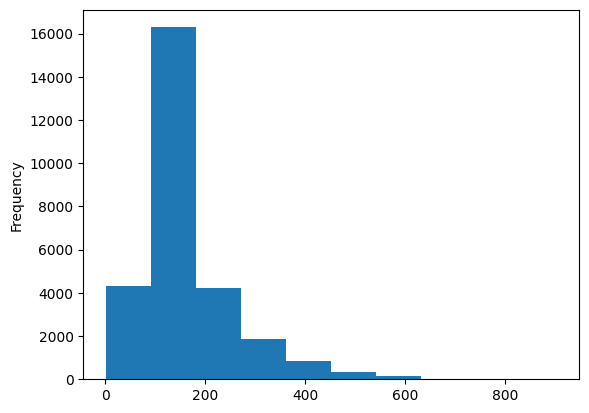

In [381]:
df.hp.plot(kind='hist');

In [383]:
hp_fr = df[df.hp.isnull()].short_description.str.lower().str.extract(r'(\d+)\s?ch').dropna()

hp_fr_values = hp_fr.iloc[:, 0].values.astype('float')

df.loc[hp_fr.index, 'hp'] = hp_fr_values

In [385]:
hp_it = df[df.hp.isnull()].short_description.str.lower().str.extract(r'(\d+)\s?cv').dropna()

hp_it_clean = hp_it.iloc[:, 0].astype('float')[hp_it.iloc[:, 0].astype('float') > 10]

df.loc[hp_it_clean.index, 'hp'] = hp_it_clean.values

In [387]:
hp_dutch = df[df.hp.isnull()].short_description.str.lower().str.extract(r'(\d+)\s?pk').dropna()

hp_dutch_clean = hp_dutch.iloc[:, 0].astype('float')

df.loc[hp_dutch_clean.index, 'hp'] = hp_dutch_clean.values

In [389]:
fr_desc = df[df.hp.isnull()].description.str.lower().str.extract(r'(\d+)\s?ch').dropna()

fr_desc_clean = fr_desc.iloc[:, 0].astype('float')

df.loc[fr_desc_clean.index, 'hp'] = fr_desc_clean.values

In [391]:
it_desc = df[df.hp.isnull()].description.str.lower().str.extract(r'(\d+)\s?cv').dropna()

it_desc_clean = it_desc.iloc[:, 0].astype('float')[it_desc.iloc[:, 0].astype('float') > 10]

df.loc[it_desc_clean.index, 'hp'] = it_desc_clean.values

In [393]:
de_desc = df[df.hp.isnull()].description.str.lower().str.extract(r'(\d+)\s?pk').dropna()

de_desc_clean = de_desc.iloc[:, 0].astype('float')

df.loc[de_desc_clean.index, 'hp'] = de_desc_clean.values

In [395]:
df['hp'] = df['hp'].fillna(
    df.groupby(['make', 'model', 'body_type', 'registration_year'])['hp'].transform(
        get_first_mode
    )
)

In [397]:
df['hp'] = df['hp'].fillna(
    df.groupby(['make', 'model', 'body_type', 'registration_year'])['hp'].transform(
        get_first_mode
    )
)

In [399]:
df['hp'] = df['hp'].fillna(
    df.groupby(['make', 'model', 'body_type'])['hp'].transform(
        get_first_mode
    )
)

In [401]:
df['hp'] = df['hp'].fillna(
    df.groupby(['make', 'body_type'])['hp'].transform(
        get_first_mode
    )
)

In [403]:
df.hp.isnull().sum()

0

### engine_size

In [405]:
df.engine_size.isnull().sum()

1403

In [407]:
cc_threshold = 10

engine_liters = np.where(
    df['engine_size'] > cc_threshold,
    round(df['engine_size'] / 1000, 1),
    df['engine_size']
)

In [409]:
df['engine_size_lt'] = engine_liters

In [411]:
cc = df[df['engine_size_lt'].isnull()].short_description.str.extract('(\d{1}\.\d{1})').dropna()

cc_clean = cc.iloc[:, 0].astype('float')

df.loc[cc_clean.index, 'engine_size_lt'] = cc_clean.values

In [413]:
cc_desc = df[df['engine_size_lt'].isnull()].description.str.extract(r'(?<![\d.])(\d\.\d)(?![\d.])').dropna()

cc_desc_clean = cc_desc.iloc[:, 0].astype('float')

df.loc[cc_desc_clean.index, 'engine_size_lt'] = cc_desc_clean.values

In [415]:
df['engine_size_lt'] = df['engine_size_lt'].fillna(
    df.groupby(['make', 'model', 'body_type', 'gearbox', 'registration_year'])['engine_size_lt'].transform(
        get_first_mode
    )
)

In [419]:
df['engine_size_lt'] = df['engine_size_lt'].fillna(
    df.groupby(['make', 'model', 'body_type', 'registration_year'])['engine_size_lt'].transform(
        get_first_mode
    )
)

In [421]:
df['engine_size_lt'] = df['engine_size_lt'].fillna(
    df.groupby(['make', 'model', 'body_type'])['engine_size_lt'].transform(
        get_first_mode
    )
)

In [423]:
df['engine_size_lt'] = df['engine_size_lt'].fillna(
    df.groupby(['make', 'model', 'registration_year'])['engine_size_lt'].transform(
        get_first_mode
    )
)

In [425]:
df['engine_size_lt'] = df['engine_size_lt'].fillna(
    df.groupby(['make', 'model'])['engine_size_lt'].transform(
        get_first_mode
    )
)

In [431]:
df.engine_size_lt.isnull().sum()

0

In [429]:
df['engine_size_lt'] = df['engine_size_lt'].fillna(
    df.groupby(['make', 'body_type'])['engine_size_lt'].transform(
        get_first_mode
    )
)

### gears

In [433]:
df.gears.isnull().sum()

9676

In [435]:
df.gears.value_counts()

gears
6.0     8412
5.0     5335
7.0     1738
8.0     1690
1.0      712
9.0      642
4.0      256
10.0     112
0.0       31
3.0       24
2.0        2
Name: count, dtype: int64

In [437]:
bad_gears = [0, 2, 3]

df.loc[df[df.gears.isin(bad_gears)].index, 'gears'] = np.nan

In [439]:
gears = df[df.gears.isnull()].short_description.str.extract(r'(\d{1,2})[-]*G[ +-]').dropna()

gears_clean = gears.iloc[:-2, 0].astype('float')

df.loc[gears_clean.index, 'gears'] = gears_clean.values

In [441]:
gears_desc = df[df.gears.isnull()].description.str.extract(r'(\d{1,2})[-]*G[ +-]').dropna()

gears_desc_clean = gears_desc.iloc[:-7, 0].astype('float')

df.loc[gears_desc_clean.index, 'gears'] = gears_desc_clean.values

In [443]:
df['gears'] = df['gears'].fillna(
    df.groupby(['make', 'model', 'body_type', 'gearbox', 'registration_year'])['gears'].transform(
        get_first_mode
    )
)

In [445]:
df['gears'] = df['gears'].fillna(
    df.groupby(['make', 'model', 'body_type', 'gearbox'])['gears'].transform(
        get_first_mode
    )
)

In [447]:
df['gears'] = df['gears'].fillna(
    df.groupby(['make', 'model', 'gearbox'])['gears'].transform(
        get_first_mode
    )
)

In [449]:
df['gears'] = df['gears'].fillna(
    df.groupby(['make', 'body_type', 'gearbox'])['gears'].transform(
        get_first_mode
    )
)

In [451]:
df['gears'] = df['gears'].fillna(
    df.groupby(['body_type', 'gearbox'])['gears'].transform(
        get_first_mode
    )
)

### co2_emissions

In [454]:
df.co2_emissions.isnull().sum()

10036

In [456]:
df['co2_emissions'] = df.co2_emissions.str.extract(r'(\d+(?:,\d{3})*|\d+) g/km')\
                        .iloc[:, 0].str.replace(',','').astype('float')

In [458]:
co2_desc = df[df.co2_emissions.isnull()].description.str.lower().str.extract(r'(\d+(?:,\d{3})*|\d+) g/km').dropna()

co2_desc_clean = co2_desc.iloc[:, 0].str.replace(',', '').astype('float')

df.loc[co2_desc_clean.index, 'co2_emissions'] = co2_desc_clean.values

In [459]:
elec_index = df[df.co2_emissions.isnull()][df[df.co2_emissions.isnull()].fuel_type == 'Electric'].index

df.loc[elec_index, 'co2_emissions'] = 0.0

In [462]:
df.loc[df[(df.co2_emissions == 0) & (df.fuel_type != 'Electric')].index, 'co2_emissions'] = np.nan

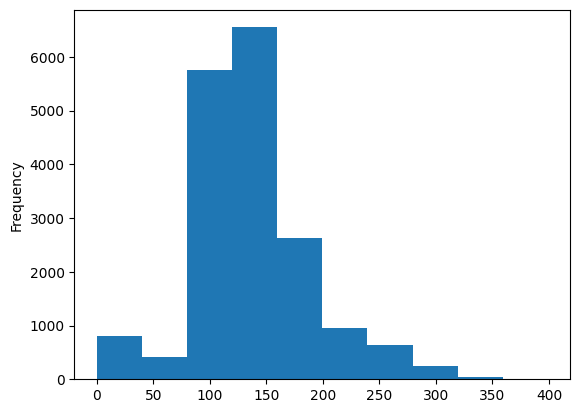

In [464]:
df.co2_emissions[df.co2_emissions < 400].plot(kind='hist');

In [466]:
df['co2_emissions'] = df['co2_emissions'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'registration_year', 'engine_size_lt'])['co2_emissions'].transform(
        lambda x: x.median()
    )
)

In [468]:
df['co2_emissions'] = df['co2_emissions'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'engine_size_lt'])['co2_emissions'].transform(
        lambda x: x.median()
    )
)

In [470]:
df['co2_emissions'] = df['co2_emissions'].fillna(
    df.groupby(['make', 'model', 'fuel_type', 'engine_size_lt'])['co2_emissions'].transform(
        lambda x: x.median()
    )
)

In [472]:
df['co2_emissions'] = df['co2_emissions'].fillna(
    df.groupby(['make', 'model', 'fuel_type'])['co2_emissions'].transform(
        lambda x: x.median()
    )
)

In [474]:
df['co2_emissions'] = df['co2_emissions'].fillna(
    df.groupby(['make', 'engine_size_lt', 'fuel_type'])['co2_emissions'].transform(
        lambda x: x.median()
    )
)

In [476]:
df['co2_emissions'] = df['co2_emissions'].fillna(
    df.groupby(['make', 'fuel_type'])['co2_emissions'].transform(
        lambda x: x.median()
    )
)

In [482]:
df.co2_emissions.isnull().sum()

0

In [480]:
df['co2_emissions'] = df['co2_emissions'].fillna(
    df.groupby(['make', 'model'])['co2_emissions'].transform(
        lambda x: x.median()
    )
)

### drivetrain

In [484]:
df.drivetrain.value_counts(dropna=False)

drivetrain
Front    12066
NaN      11737
4WD       3252
Rear      1575
Name: count, dtype: int64

In [486]:
fronts = df[df.drivetrain.isnull()].short_description.str.lower().str.contains(r'front')

df.loc[fronts[fronts==True].index, 'drivetrain'] = 'Front'

In [488]:
fours = df[df.drivetrain.isnull()].short_description.str.lower().str.contains(r'4x4|4 x 4')

df.loc[fours[fours==True].index, 'drivetrain'] = '4WD'

In [490]:
desc_front = df[df.drivetrain.isnull()].description.str.lower().str.extract(r'(fwd)').dropna().index

df.loc[desc_front, 'drivetrain'] = 'Front'

In [492]:
desc_four = df[df.drivetrain.isnull()].description.str.lower().str.extract(r'(4x4| 4 x 4)').dropna().index

df.loc[desc_four, 'drivetrain'] = '4WD'

In [494]:
desc_rear = df[df.drivetrain.isnull()].description.str.lower().str.extract(r'(rear-wheel|rear wheel)').dropna().index

df.loc[desc_rear, 'drivetrain'] = 'Rear'

In [496]:
df['drivetrain'] = df['drivetrain'].fillna(
    df.groupby(['make', 'model', 'body_type', 'registration_year', 'gearbox', 'gears'])['drivetrain'].transform(
        get_first_mode
    )
)

In [498]:
df['drivetrain'] = df['drivetrain'].fillna(
    df.groupby(['make', 'model', 'body_type', 'gearbox', 'gears'])['drivetrain'].transform(
        get_first_mode
    )
)

In [500]:
df['drivetrain'] = df['drivetrain'].fillna(
    df.groupby(['make', 'model', 'body_type', 'gears'])['drivetrain'].transform(
        get_first_mode
    )
)

In [502]:
df['drivetrain'] = df['drivetrain'].fillna(
    df.groupby(['make', 'model', 'body_type', 'gearbox'])['drivetrain'].transform(
        get_first_mode
    )
)

In [504]:
df['drivetrain'] = df['drivetrain'].fillna(
    df.groupby(['make', 'model', 'body_type'])['drivetrain'].transform(
        get_first_mode
    )
)

In [506]:
df['drivetrain'] = df['drivetrain'].fillna(
    df.groupby(['make', 'model', 'gearbox'])['drivetrain'].transform(
        get_first_mode
    )
)

In [508]:
df['drivetrain'] = df['drivetrain'].fillna(
    df.groupby(['make', 'model', 'gears'])['drivetrain'].transform(
        get_first_mode
    )
)

In [510]:
df['drivetrain'] = df['drivetrain'].fillna(
    df.groupby(['make', 'body_type', 'gearbox'])['drivetrain'].transform(
        get_first_mode
    )
)

In [512]:
df.drivetrain.isnull().sum()

0

### cylinders

In [514]:
df.cylinders.value_counts(dropna=False)

cylinders
4.0     13068
NaN      9778
3.0      3258
6.0      1013
5.0       799
8.0       539
2.0       103
0.0        35
1.0        21
12.0        8
7.0         6
26.0        1
16.0        1
Name: count, dtype: int64

In [516]:
bad_cylinders = [26.0, 16.0, 7.0, 1.0]

df.loc[df[df.cylinders.isin(bad_cylinders)].index, 'cylinders'] = np.nan

In [518]:
cyl_desc = df[df.cylinders.isnull()].description.str.lower().str.extract(r'(\d+ cylin)').dropna()

df.loc[cyl_desc.index, 'cylinders'] = 6.0

In [520]:
pattern_cyl = r'(\d+)(?:-|\s)?(?:zylinder|zyl\.?|cylindres|cyl\.?|cilindros|cil\.?|cilindri|cil\.?|cilinders|cilinder|cyl\.?)\b'

cylinders = df[df.cylinders.isnull()].description.str.lower().str.extract(pattern_cyl).dropna()

cylinders_clean = cylinders.iloc[:, 0].astype('float')

df.loc[cylinders_clean.index, 'cylinders'] = cylinders_clean.values

In [522]:
electric_cylinder_index = df[(df.cylinders.isnull()) & (df.fuel_type == 'Electric')].index

df.loc[electric_cylinder_index, 'cylinders'] = 0.0

In [524]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'gearbox', 'gears', 
                'registration_year', 'engine_size_lt'])['cylinders'].transform(
        get_first_mode
    )
)

In [526]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'gearbox', 'gears', 
                'engine_size_lt'])['cylinders'].transform(
        get_first_mode
    )
)

In [528]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'gearbox', 'gears', 
                'engine_size_lt'])['cylinders'].transform(
        get_first_mode
    )
)

In [530]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'gears', 
                'engine_size_lt'])['cylinders'].transform(
        get_first_mode
    )
)

In [532]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'gearbox', 
                'engine_size_lt'])['cylinders'].transform(
        get_first_mode
    )
)

In [534]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 
                'engine_size_lt'])['cylinders'].transform(
        get_first_mode
    )
)

In [536]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type'])['cylinders'].transform(
        get_first_mode
    )
)

In [538]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'model', 'body_type', 'engine_size_lt'])['cylinders'].transform(
        get_first_mode
    )
)

In [540]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'model', 'body_type'])['cylinders'].transform(
        get_first_mode
    )
)

In [542]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'model', 'engine_size_lt'])['cylinders'].transform(
        get_first_mode
    )
)

In [544]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'fuel_type', 'engine_size_lt'])['cylinders'].transform(
        get_first_mode
    )
)

In [546]:
df['cylinders'] = df['cylinders'].fillna(
    df.groupby(['make', 'fuel_type'])['cylinders'].transform(
        get_first_mode
    )
)

In [548]:
df.cylinders.isnull().sum()

0

### fuel_consumption

In [550]:
df.loc[456, 'fuel_consumption']

'13.5 l/100 km (comb.),20.3 l/100 km (city),9.6 l/100 km (country)'

In [552]:
df['fuel_consumption_comb'] = df.fuel_consumption.str.extract(r'(\d+.\d+) l/100 km').astype('float')

In [554]:
df['fuel_consumption_comb'].isnull().sum()

6797

In [556]:
desc_f_cons = df[df['fuel_consumption_comb'].isnull()].description.str.extract(r'(\d+(?:\.\d+)?)\s*[lL]/100\s*[kK][mM]').dropna()

desc_f_cons_clean = desc_f_cons.iloc[:, 0].astype('float')

df.loc[desc_f_cons_clean.index, 'fuel_consumption_comb'] = desc_f_cons_clean.values

In [558]:
df.loc[df[df.fuel_type == 'Electric'].index, 'fuel_consumption_comb'] = 0.0

In [560]:
df['fuel_consumption_comb'] = df['fuel_consumption_comb'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'gearbox', 'gears', 
                'registration_year', 'engine_size_lt'])['fuel_consumption_comb'].transform(
        lambda x: x.median()
    )
)

In [562]:
df['fuel_consumption_comb'] = df['fuel_consumption_comb'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'gearbox', 'gears', 
                'registration_year', 'engine_size_lt'])['fuel_consumption_comb'].transform(
        lambda x: x.median()
    )
)

In [564]:
df['fuel_consumption_comb'] = df['fuel_consumption_comb'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'gearbox', 'gears', 
                'engine_size_lt'])['fuel_consumption_comb'].transform(
        lambda x: x.median()
    )
)

In [566]:
df['fuel_consumption_comb'] = df['fuel_consumption_comb'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'gears', 
                'engine_size_lt'])['fuel_consumption_comb'].transform(
        lambda x: x.median()
    )
)

In [568]:
df['fuel_consumption_comb'] = df['fuel_consumption_comb'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 'gearbox', 
                'engine_size_lt'])['fuel_consumption_comb'].transform(
        lambda x: x.median()
    )
)

In [570]:
df['fuel_consumption_comb'] = df['fuel_consumption_comb'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type', 
                'engine_size_lt'])['fuel_consumption_comb'].transform(
        lambda x: x.median()
    )
)

In [572]:
df['fuel_consumption_comb'] = df['fuel_consumption_comb'].fillna(
    df.groupby(['make', 'model', 'body_type', 'fuel_type'])['fuel_consumption_comb'].transform(
        lambda x: x.median()
    )
)

In [574]:
df['fuel_consumption_comb'] = df['fuel_consumption_comb'].fillna(
    df.groupby(['make', 'model', 'fuel_type'])['fuel_consumption_comb'].transform(
        lambda x: x.median()
    )
)

In [576]:
df['fuel_consumption_comb'] = df['fuel_consumption_comb'].fillna(
    df.groupby(['make', 'body_type', 'fuel_type'])['fuel_consumption_comb'].transform(
        lambda x: x.median()
    )
)

In [578]:
df['fuel_consumption_comb'] = df['fuel_consumption_comb'].fillna(
    df.groupby(['make', 'fuel_type'])['fuel_consumption_comb'].transform(
        lambda x: x.median()
    )
)

In [580]:
df['fuel_consumption_comb'] = df['fuel_consumption_comb'].fillna(
    df.groupby(['fuel_type'])['fuel_consumption_comb'].transform(
        lambda x: x.median()
    )
)

In [582]:
df.fuel_consumption_comb.isnull().sum()

0

### comfort_convenience

In [584]:
df.comfort_convenience.isnull().sum()

3197

In [586]:
df['comfort_package'] = df.comfort_convenience.str.count(',') + 1

In [588]:
df['comfort_package'].value_counts()

comfort_package
5.0     1429
6.0     1360
3.0     1224
7.0     1189
4.0     1108
17.0    1100
15.0    1081
8.0     1070
16.0    1062
18.0    1057
19.0    1055
14.0    1052
20.0    1050
10.0    1023
11.0     987
12.0     980
13.0     921
21.0     880
9.0      873
22.0     832
2.0      765
23.0     731
24.0     650
1.0      585
25.0     428
26.0     347
27.0     200
28.0     150
29.0     118
30.0      62
31.0      34
32.0      15
33.0      12
34.0       3
Name: count, dtype: int64

In [590]:
bins = [0, 7, 15, float('inf')]
labels = ['Standard', 'Premium', 'Deluxe']

df['comfort_package'] = pd.cut(df['comfort_package'], bins=bins, labels=labels, right=True, include_lowest=False)

In [592]:
df['comfort_package'] = df['comfort_package'].fillna(
    df.groupby(['make', 'model', 'body_type',
                'registration_year'])['comfort_package'].transform(
        get_first_mode
    )
)

In [594]:
df['comfort_package'] = df['comfort_package'].fillna(
    df.groupby(['make', 'model', 'body_type'])['comfort_package'].transform(
        get_first_mode
    )
)

In [596]:
df['comfort_package'] = df['comfort_package'].fillna(
    df.groupby(['make', 'body_type', 'engine_size_lt'])['comfort_package'].transform(
        get_first_mode
    )
)

In [598]:
df['comfort_package'] = df['comfort_package'].fillna(
    df.groupby(['make', 'body_type'])['comfort_package'].transform(
        get_first_mode
    )
)

In [602]:
df['comfort_package'] = df['comfort_package'].fillna(
    df.groupby(['make', 'model'])['comfort_package'].transform(
        get_first_mode
    )
)

### entertainment_media

In [606]:
df['media_package'] = df.entertainment_media.str.count(',') + 1

In [608]:
df.media_package.value_counts()

media_package
2.0     2555
3.0     2444
4.0     2241
1.0     2157
7.0     2105
8.0     2058
6.0     2040
5.0     2019
9.0     1800
10.0    1602
11.0    1196
12.0     840
13.0     448
14.0     115
15.0      20
16.0       4
Name: count, dtype: int64

In [610]:
bins = [0, 4, 9, float('inf')]
labels = ['Standard', 'Premium', 'Deluxe']

df['media_package'] = pd.cut(df['media_package'], bins=bins, labels=labels, right=True, include_lowest=False)

In [612]:
df['media_package'] = df['media_package'].fillna(
    df.groupby(['make', 'model', 'body_type',
                'registration_year'])['media_package'].transform(
        get_first_mode
    )
)

In [614]:
df['media_package'] = df['media_package'].fillna(
    df.groupby(['make', 'model', 'body_type'])['media_package'].transform(
        get_first_mode
    )
)

In [616]:
df['media_package'] = df['media_package'].fillna(
    df.groupby(['make', 'registration_year',
                'body_type'])['media_package'].transform(
        get_first_mode
    )
)

In [618]:
df['media_package'] = df['media_package'].fillna(
    df.groupby(['make',
                'model'])['media_package'].transform(
        get_first_mode
    )
)

In [622]:
df['media_package'] = df['media_package'].fillna(
    df.groupby(['make',
                'body_type'])['media_package'].transform(
        get_first_mode
    )
)

In [624]:
df.media_package.isnull().sum()

0

### safety_security

In [626]:
df['safety_package'] = df.safety_security.str.count(',') + 1

In [628]:
df.safety_package.value_counts()

safety_package
9.0     1706
8.0     1370
10.0    1310
11.0    1274
13.0    1274
14.0    1237
12.0    1227
15.0    1176
7.0     1142
16.0    1111
18.0     976
17.0     927
19.0     907
22.0     904
21.0     868
6.0      848
23.0     840
24.0     826
20.0     802
25.0     733
26.0     686
1.0      662
4.0      469
5.0      424
3.0      408
27.0     372
2.0      262
28.0     247
29.0     154
30.0     153
31.0      60
32.0      27
34.0      18
33.0      12
35.0       2
36.0       1
Name: count, dtype: int64

In [630]:
bins = [0, 7, 15, float('inf')]
labels = ['Standard', 'Premium', 'Deluxe']

df['safety_package'] = pd.cut(df['safety_package'], bins=bins, labels=labels, right=True, include_lowest=False)

In [632]:
df['safety_package'] = df['safety_package'].fillna(
    df.groupby(['make', 'model', 'body_type',
                'registration_year'])['safety_package'].transform(
        get_first_mode
    )
)

In [634]:
df['safety_package'] = df['safety_package'].fillna(
    df.groupby(['make', 'model', 'body_type'])['safety_package'].transform(
        get_first_mode
    )
)

In [636]:
df['safety_package'] = df['safety_package'].fillna(
    df.groupby(['make', 'body_type'])['safety_package'].transform(
        get_first_mode
    )
)

In [638]:
df['safety_package'] = df['safety_package'].fillna(
    df.groupby(['make', 'model'])['safety_package'].transform(
        get_first_mode
    )
)

In [640]:
df.safety_package.isnull().sum()

0

### extras

In [642]:
df['extras_package'] = df.extras.str.count(',') + 1

In [644]:
df.extras_package.value_counts()

extras_package
1.0     4874
2.0     3105
3.0     2797
4.0     2315
5.0     2024
6.0     1597
7.0     1494
8.0     1137
9.0      997
10.0     880
11.0     650
12.0     565
13.0     378
14.0     271
15.0     191
16.0     108
17.0      55
18.0      27
19.0      10
20.0       3
26.0       2
Name: count, dtype: int64

In [646]:
bins = [0, 3, 8, float('inf')]
labels = ['Standard', 'Premium', 'Deluxe']

df['extras_package'] = pd.cut(df['extras_package'], bins=bins, labels=labels, right=True, include_lowest=False)

In [648]:
df['extras_package'] = df['extras_package'].fillna(
    df.groupby(['make', 'model', 'body_type', 'gearbox',
                'registration_year'])['extras_package'].transform(
        get_first_mode
    )
)

In [650]:
df['extras_package'] = df['extras_package'].fillna(
    df.groupby(['make', 'model', 'body_type', 'gearbox'])['extras_package'].transform(
        get_first_mode
    )
)

In [652]:
df['extras_package'] = df['extras_package'].fillna(
    df.groupby(['make', 'model', 'body_type'])['extras_package'].transform(
        get_first_mode
    )
)

In [654]:
df['extras_package'] = df['extras_package'].fillna(
    df.groupby(['make', 'model', 'registration_year'])['extras_package'].transform(
        get_first_mode
    )
)

In [656]:
df['extras_package'] = df['extras_package'].fillna(
    df.groupby(['make', 'body_type'])['extras_package'].transform(
        get_first_mode
    )
)

In [658]:
df.extras_package.isnull().sum()

0

### empty_weight

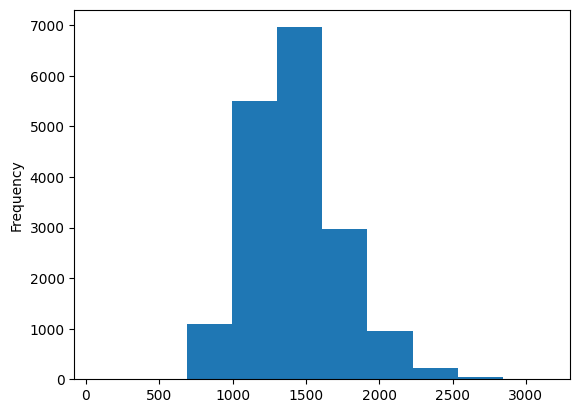

In [660]:
df.empty_weight[df.empty_weight < 4000].plot(kind='hist');

In [662]:
df.empty_weight.isnull().sum()

10872

In [664]:
weight = df[df.empty_weight.isnull()].description.str.lower().str.extract('(\d+\.?\d+) kg').dropna()

weight_clean = weight.iloc[:, 0].str.replace('.', '').astype('float')

df.loc[weight_clean.index, 'empty_weight'] = weight_clean.values

In [666]:
df['empty_weight'] = df['empty_weight'].fillna(
    df.groupby(['make', 'model', 'body_type', 'engine_size_lt',
                'registration_year', 'cylinders', 'fuel_type'])['empty_weight'].transform(
        lambda x: x.median()
    )
)

In [668]:
df['empty_weight'] = df['empty_weight'].fillna(
    df.groupby(['make', 'model', 'body_type', 
                'cylinders', 'fuel_type'])['empty_weight'].transform(
        lambda x: x.median()
    )
)

In [670]:
df['empty_weight'] = df['empty_weight'].fillna(
    df.groupby(['make', 'model', 'body_type', 
                'fuel_type'])['empty_weight'].transform(
        lambda x: x.median()
    )
)

In [672]:
df['empty_weight'] = df['empty_weight'].fillna(
    df.groupby(['make', 'model', 'body_type', 
                'cylinders'])['empty_weight'].transform(
        lambda x: x.median()
    )
)

In [674]:
df['empty_weight'] = df['empty_weight'].fillna(
    df.groupby(['make', 'model', 'fuel_type', 
                'cylinders'])['empty_weight'].transform(
        lambda x: x.median()
    )
)

In [676]:
df['empty_weight'] = df['empty_weight'].fillna(
    df.groupby(['make', 'body_type', 'fuel_type', 
                'cylinders'])['empty_weight'].transform(
        lambda x: x.median()
    )
)

In [678]:
df['empty_weight'] = df['empty_weight'].fillna(
    df.groupby(['make', 'body_type', 
                'cylinders'])['empty_weight'].transform(
        lambda x: x.median()
    )
)

In [680]:
df['empty_weight'] = df['empty_weight'].fillna(
    df.groupby(['make', 'body_type', 
               ])['empty_weight'].transform(
        lambda x: x.median()
    )
)

In [682]:
df.empty_weight.isnull().sum()

0

### emission_class

In [684]:
df.emission_class.value_counts(dropna=False)

emission_class
NaN             10771
Euro 6           6418
Euro 6d-TEMP     3399
Euro 6d          2858
Euro 5           2389
Euro 4           1743
Euro 3            523
Euro 2            217
Euro 1            172
Euro 6c           140
Name: count, dtype: int64

**description**

In [686]:
euro_6d_temp = df[df.emission_class.isnull()].description.str.lower().str.extract(r'(euro\s?6d-temp)').dropna()

df.loc[euro_6d_temp.index, 'emission_class'] = 'Euro 6d-TEMP'

In [688]:
euro_6d = df[df.emission_class.isnull()].description.str.lower().str.extract(r'(euro\s?6d)').dropna()

df.loc[euro_6d.index, 'emission_class'] = 'Euro 6d'

In [690]:
euro_6c = df[df.emission_class.isnull()].description.str.lower().str.extract(r'(euro\s?6c)').dropna()

df.loc[euro_6c.index, 'emission_class'] = 'Euro 6c'

In [692]:
euro_6 = df[df.emission_class.isnull()].description.str.lower().str.extract(r'(euro\s?6)').dropna()

df.loc[euro_6.index, 'emission_class'] = 'Euro 6'

In [694]:
euro_5 = df[df.emission_class.isnull()].description.str.lower().str.extract(r'(euro\s?5)').dropna()

df.loc[euro_5.index, 'emission_class'] = 'Euro 5'

In [696]:
euro_4 = df[df.emission_class.isnull()].description.str.lower().str.extract(r'(euro\s?4)').dropna()

df.loc[euro_4.index, 'emission_class'] = 'Euro 4'

In [698]:
euro_3 = df[df.emission_class.isnull()].description.str.lower().str.extract(r'(euro\s?3)').dropna()

df.loc[euro_3.index, 'emission_class'] = 'Euro 3'

In [700]:
euro_2 = df[df.emission_class.isnull()].description.str.lower().str.extract(r'(euro\s?2)').dropna()

df.loc[euro_2.index, 'emission_class'] = 'Euro 2'

In [702]:
euro_1 = df[df.emission_class.isnull()].description.str.lower().str.extract(r'(euro\s?1)').dropna()

df.loc[euro_1.index, 'emission_class'] = 'Euro 1'

**short_description**

In [705]:
sd_e6d_temp = df[df.emission_class.isnull()].short_description.str.lower().str.extract(r'(euro\s?6d-temp)').dropna()

df.loc[sd_e6d_temp.index, 'emission_class'] = 'Euro 6d-TEMP'

In [707]:
sd_e6d = df[df.emission_class.isnull()].short_description.str.lower().str.extract(r'(euro\s?6d)').dropna()

df.loc[sd_e6d.index, 'emission_class'] = 'Euro 6d'

In [709]:
sd_e6 = df[df.emission_class.isnull()].short_description.str.lower().str.extract(r'(euro\s?6)').dropna()

df.loc[sd_e6.index, 'emission_class'] = 'Euro 6'

**Domain Knowledge:** European emission standarts were initiated in 1992 with Euro 1. Euro 2, Euro 3, Euro 4, Euro 5 and Euro 6 were implemented in 1996, 2000, 2005, 2009 and 2014, respectively.

In [712]:
before_1992 = df[(df.registration_year < 1992) & (df.emission_class.notnull())].index

df.loc[before_1992, 'emission_class'] = 'Under Class'

In [714]:
before_1992_nan = df[df.emission_class.isnull()][df.registration_year < 1992].index

df.loc[before_1992_nan, 'emission_class'] = 'Under Class'

In [716]:
df.loc[df[df.emission_class.isnull()][df.registration_year < 1996].index, 'emission_class'] = 'Euro 1'
df.loc[df[df.emission_class.isnull()][df.registration_year < 2000].index, 'emission_class'] = 'Euro 2'
df.loc[df[df.emission_class.isnull()][df.registration_year < 2005].index, 'emission_class'] = 'Euro 3'
df.loc[df[df.emission_class.isnull()][df.registration_year < 2009].index, 'emission_class'] = 'Euro 4'
df.loc[df[df.emission_class.isnull()][df.registration_year < 2014].index, 'emission_class'] = 'Euro 5'
df.loc[df[df.emission_class.isnull()][df.registration_year >= 2014].index, 'emission_class'] = 'Euro 6'

In [718]:
df['emission_class'] = df.emission_class.apply(lambda x: 'Euro 6' if x == 'Euro 6c' or x == 'Euro 6d' or x == 'Euro 6d-TEMP' else x)

In [720]:
df.emission_class.isnull().sum()

0

### upholstery

In [723]:
df.upholstery.value_counts(dropna=False)

upholstery
NaN             10020
Cloth            8736
Full Leather     5439
Part Leather     2835
Alcantara         764
Other             628
Velour            208
Name: count, dtype: int64

In [725]:
alcantara = df[df.upholstery.isnull()].description.str.lower().str.extract('(alcantara)').dropna()

df.loc[alcantara.index, 'upholstery'] = 'Alcantara'

In [727]:
velour = df[df.upholstery.isnull()].description.str.lower().str.extract('(velour)').dropna()

df.loc[velour.index, 'upholstery'] = 'Velour'

In [729]:
leather = df[df.upholstery.isnull()].description.str.lower().str.extract('(leather)').dropna()

df.loc[leather.index, 'upholstery'] = 'Part Leather'

In [731]:
df['upholstery'] = df['upholstery'].fillna(
    df.groupby(['make', 'model', 'body_type', 'drivetrain', 'gearbox',
                'registration_year'])['upholstery'].transform(
        get_first_mode
    )
)

In [733]:
df['upholstery'] = df['upholstery'].fillna(
    df.groupby(['make', 'model', 'body_type', 'drivetrain', 'gearbox'])['upholstery'].transform(
        get_first_mode
    )
)

In [735]:
df['upholstery'] = df['upholstery'].fillna(
    df.groupby(['make', 'model', 'body_type', 'drivetrain'])['upholstery'].transform(
        get_first_mode
    )
)

In [737]:
df['upholstery'] = df['upholstery'].fillna(
    df.groupby(['make', 'model', 'body_type'])['upholstery'].transform(
        get_first_mode
    )
)

In [745]:
df.upholstery.isnull().sum()

0

In [741]:
df['upholstery'] = df['upholstery'].fillna(
    df.groupby(['make', 'model', 'drivetrain'])['upholstery'].transform(
        get_first_mode
    )
)

In [743]:
df['upholstery'] = df['upholstery'].fillna(
    df.groupby(['make', 'body_type', 'drivetrain'])['upholstery'].transform(
        get_first_mode
    )
)

### previous_owner

In [747]:
df.previous_owner.value_counts(dropna=False)

previous_owner
NaN     14615
1.0      9746
2.0      3221
3.0       699
4.0       184
5.0        69
6.0        37
7.0        22
8.0        16
9.0        14
12.0        3
10.0        2
14.0        1
13.0        1
Name: count, dtype: int64

In [749]:
def mileage_class(value):
    if value < 50000:
        return '0-50k'
    elif value < 100000:
        return '50-100k'
    elif value < 150000:
        return '100-150k'
    elif value < 200000:
        return '150-200k'
    elif value < 500000:
        return '200-500k'
    else:
        return 'above 500k'


df['mileage_class'] = df.mileage.apply(mileage_class)

In [751]:
df.loc[df[df.previous_owner.isnull()][df.mileage == 0].index, 'previous_owner'] = 0.0

In [753]:
df.loc[df[df.previous_owner.isnull()][df.type == 'Pre-registered'].index, 'previous_owner'] = 0.0

In [755]:
df.loc[df[df.previous_owner.isnull()][df.type == 'Demonstration'].index, 'previous_owner'] = 0.0

In [757]:
df['previous_owner'] = df['previous_owner'].fillna(
    df.groupby(['make', 'model', 'mileage_class', 'type',
                'registration_year'])['previous_owner'].transform(
        get_first_mode
    )
)

In [769]:
df.previous_owner.isnull().sum()

14

In [761]:
df['previous_owner'] = df['previous_owner'].fillna(
    df.groupby(['make', 'model', 'mileage_class', 'type'])['previous_owner'].transform(
        get_first_mode
    )
)

In [763]:
df['previous_owner'] = df['previous_owner'].fillna(
    df.groupby(['make', 'model', 'mileage_class', 'type',
                'registration_year'])['previous_owner'].transform(
        get_first_mode
    )
)

In [765]:
df['previous_owner'] = df['previous_owner'].fillna(
    df.groupby(['make', 'model', 'mileage_class', 'type'])['previous_owner'].transform(
        get_first_mode
    )
)

In [767]:
df['previous_owner'] = df['previous_owner'].fillna(
    df.groupby(['make', 'mileage_class', 'type'])['previous_owner'].transform(
        get_first_mode
    )
)

In [771]:
df['previous_owner'] = df['previous_owner'].fillna(
    df.groupby(['make', 'model', 'type'])['previous_owner'].transform(
        get_first_mode
    )
)

In [777]:
df.previous_owner.isnull().sum()

0

In [775]:
df['previous_owner'] = df['previous_owner'].fillna(
    df.groupby(['make', 'type'])['previous_owner'].transform(
        get_first_mode
    )
)

### Final cleaning

In [780]:
df.isnull().sum()

make_model                   0
short_description          213
make                         0
model                        0
location                     0
price                        0
body_type                    0
type                         0
doors                        0
country_version          11741
offer_number              5530
warranty                     0
mileage                      0
first_registration           2
gearbox                      0
fuel_type                    0
color                        0
paint                        0
description                671
seller                       0
seats                        0
power                      572
engine_size               1403
gears                        0
co2_emissions                0
manufacturer_color        6843
drivetrain                   0
cylinders                    0
fuel_consumption          5245
comfort_convenience       3197
entertainment_media       4986
safety_security           3215
extras  

In [782]:
## make_model column has incorrect values, so it needs to be recreated by make and model.

df['make_model'] = df.make + ' ' + df.model

In [784]:
cols = [
    'price', 'make', 'make_model', 'body_type', 'type', 'doors', 'warranty', 'mileage', 'gearbox', 'fuel_type',
    'color', 'paint', 'seller', 'seats', 'gears', 'co2_emissions', 'drivetrain', 'cylinders', 'empty_weight',
    'emission_class', 'upholstery', 'previous_owner', 'registration_year', 'hp', 'engine_size_lt',
    'fuel_consumption_comb', 'comfort_package', 'media_package', 'safety_package', 'extras_package'
]

df_final = df[cols].reset_index(drop=True)

In [786]:
df_final.shape

(28630, 30)

In [788]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28630 entries, 0 to 28629
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   price                  28630 non-null  float64 
 1   make                   28630 non-null  object  
 2   make_model             28630 non-null  object  
 3   body_type              28630 non-null  object  
 4   type                   28630 non-null  object  
 5   doors                  28630 non-null  float64 
 6   warranty               28630 non-null  object  
 7   mileage                28630 non-null  float64 
 8   gearbox                28630 non-null  object  
 9   fuel_type              28630 non-null  object  
 10  color                  28630 non-null  object  
 11  paint                  28630 non-null  object  
 12  seller                 28630 non-null  object  
 13  seats                  28630 non-null  float64 
 14  gears                  28630 non-null 

In [790]:
df_final.to_csv('car_project_part2.csv', index=False)